In [51]:
VER = 2
PROD = 4
LEN = 1440

TRAIN_MODEL = True
USE_INTERNET = True
PATH = "playground-series-s5e1/"

In [52]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt

train = pd.read_csv('playground-series-s5e1/train.csv')
train.date = pd.to_datetime(train.date)

print("Train shape:", train.shape)
train.head()

Train shape: (230130, 6)


id       date country              store             product  num_sold
0   0 2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
1   1 2010-01-01  Canada  Discount Stickers              Kaggle     973.0
2   2 2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0
3   3 2010-01-01  Canada  Discount Stickers            Kerneler     423.0
4   4 2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0

In [ ]:
import requests

def get_gdp_per_capita(alpha3, year):
    url = 'https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json'
    response = requests.get(url.format(alpha3, year))
    return response.json()[1][0]['value']
alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
train['alpha3'] = train['country'].map(dict(zip(np.sort(train['country'].unique()), alpha3s)))
years = np.sort(train.date.dt.year.unique())
train['year'] = train.date.dt.year
if USE_INTERNET:
    gdp = np.array([
        [get_gdp_per_capita(alpha3, year) for year in years]
        for alpha3 in alpha3s
    ])
    gdp = pd.DataFrame(gdp, index=alpha3s, columns=years)
else:
    gdp = pd.read_csv(f"{PATH}gdp0.csv")
    gdp = gdp.set_index("Unnamed: 0")
    gdp = gdp.rename(columns=lambda x: int(x))
train['GDP'] = train.apply(lambda s: gdp.loc[s['alpha3'], s['year']], axis=1)
train = train.drop(['alpha3','year'],axis=1)
train.head()

In [ ]:
train["num_sold"] /= train["GDP"]
store_ratio = train.groupby("store").num_sold.mean().to_dict()
train["store_ratio"] = train["store"].map(store_ratio)
train["num_sold"] /= train["store_ratio"]
train.head()

id       date country              store             product  num_sold  \
0   0 2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN   
1   1 2010-01-01  Canada  Discount Stickers              Kaggle  2.283955   
2   2 2010-01-01  Canada  Discount Stickers        Kaggle Tiers  2.126684   
3   3 2010-01-01  Canada  Discount Stickers            Kerneler  0.992922   
4   4 2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode  1.152541   

            GDP  store_ratio  
0  47560.666601     0.008957  
1  47560.666601     0.008957  
2  47560.666601     0.008957  
3  47560.666601     0.008957  
4  47560.666601     0.008957

Countries: ['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore']
Stores: ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart']
Products: ['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode']


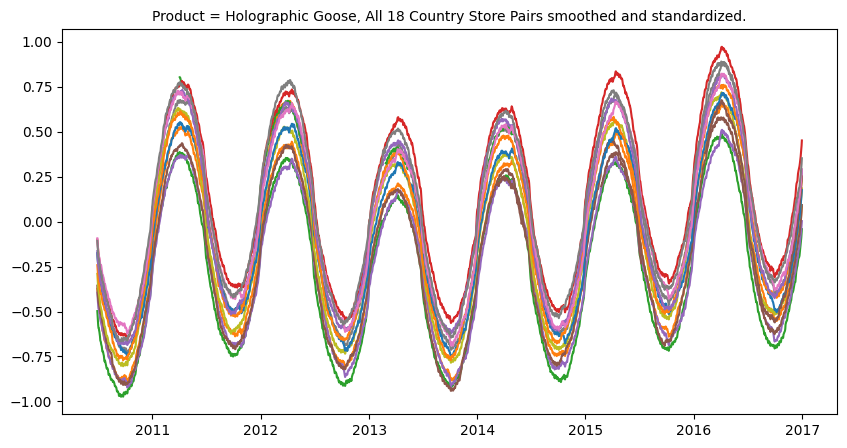

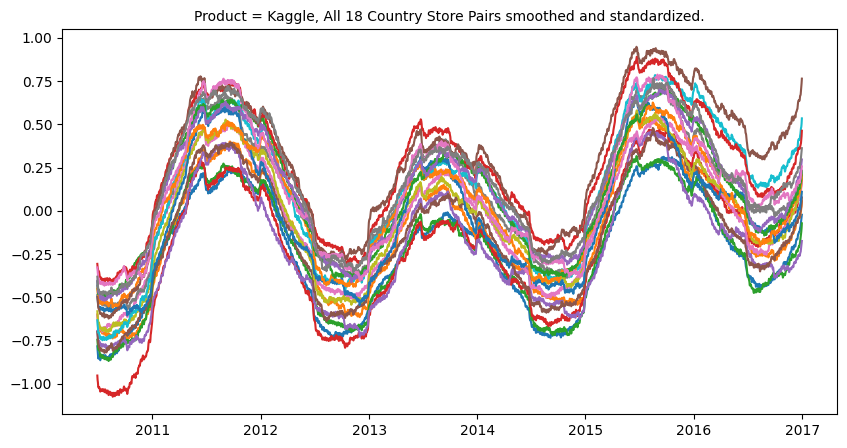

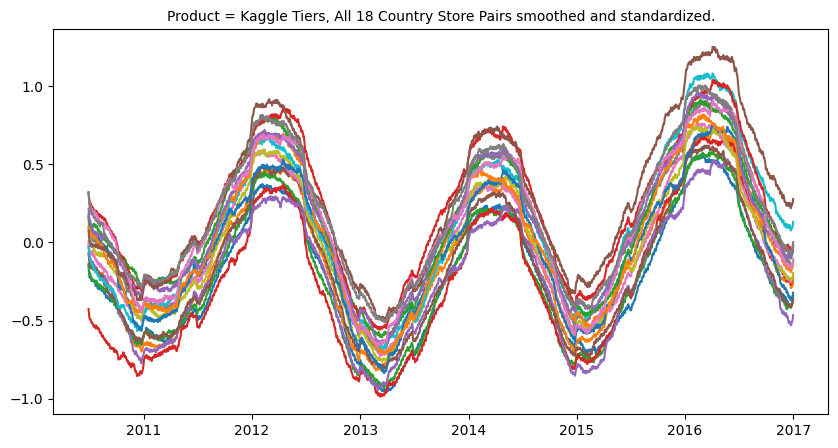

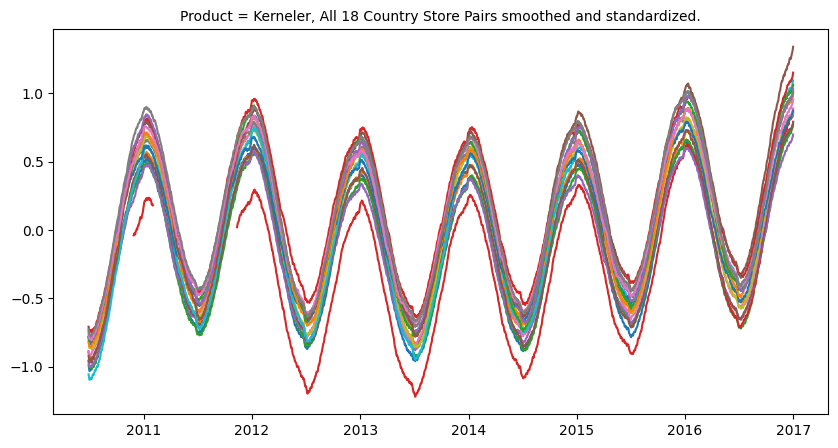

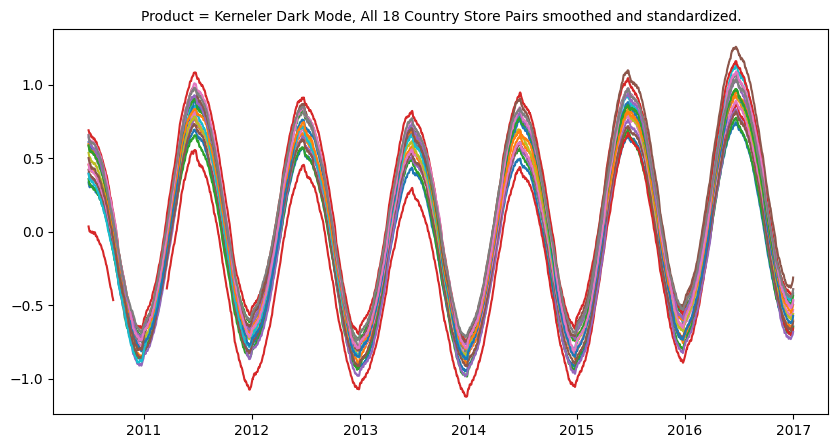

In [ ]:
C = list( train.country.unique() )
S = list( train.store.unique() )
P = list( train["product"].unique() )
print("Countries:", C )
print("Stores:", S )
print("Products:", P)

# DATA IS PRODUCT X 7 YEARS X STORE+COUNTRY
data = np.zeros( (5,2557,18) )
for i in range(5):
    for j in range(3):
        for k in range(6):
            f = 1 
            if k==3: f=1.15 # FUDGE FACTOR FOR KENYA
            df = train.loc[(train.country==C[k])&(train.store==S[j])&(train["product"]==P[i])].copy()
            data[i,:,j*6+k] = df["num_sold"].values*f

# COMPUTE MEANS AND STDS
means = {}; stds = {}
for k in range(5):
    m = np.nanmean( data[k,:,:] )
    s = np.nanstd( data[k,:,:] )
    means[k]=m; stds[k]=s

# PLOT ALL TIME SERIES DATA
for i in range(5):
    plt.figure(figsize=(10,5))
    for j in range(3):
        for k in range(6):
            f = 1
            if k==3: f=1.15
            df = train.loc[(train.country==C[k])&(train.store==S[j])&(train["product"]==P[i])].copy()
            df["smooth_sold"] = df["num_sold"].rolling(window=180).mean()
            m = means[i]; s = stds[i]
            plt.plot(df["date"], (df["smooth_sold"]*f-m)/s )
            data[i,:,j*6+k] = (df["num_sold"].values*f-m)/s
    plt.title(f"Product = {P[i]}, All 18 Country Store Pairs smoothed and standardized.",size=10)
    plt.show()

In [ ]:
import tensorflow as tf

In [32]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, product=0, f_length=768, t_length=32): 

        self.data = np.expand_dims(data,axis=-1)
        nans = np.isnan(self.data).astype('float32')
        self.data = np.concatenate([self.data,nans],axis=-1)
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.product = product
        self.f_length = f_length
        self.t_length = t_length
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int(np.ceil(32*1024/self.batch_size))
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( 32*1024 )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
    
        SIZE = self.f_length
        TARGET = self.t_length
        X = np.zeros((len(indexes),SIZE,2),dtype='float32')
        y = np.zeros((len(indexes),TARGET),dtype='float32')
        
        for k in range(len(indexes)):
            r = np.random.randint(0,self.data.shape[2])
            a = np.random.randint(0,self.data.shape[1]-SIZE-TARGET)
            y[k,:] = self.data[self.product,a+SIZE:a+SIZE+TARGET,r,0]
            while np.isnan(y[k,:]).sum()>0:
                r = np.random.randint(0,self.data.shape[2])
                a = np.random.randint(0,self.data.shape[1]-SIZE-TARGET)
                y[k,:] = self.data[self.product,a+SIZE:a+SIZE+TARGET,r,0]
            X[k,:,:] = self.data[self.product,a:a+SIZE,r,:]

        return np.nan_to_num(X),np.nan_to_num(y)

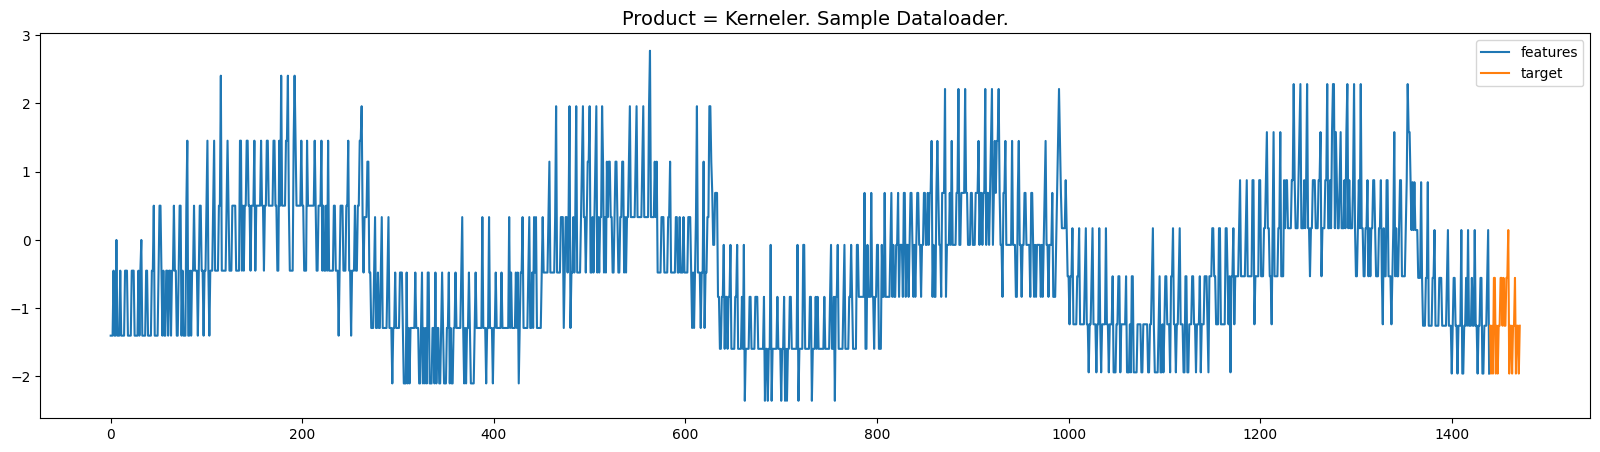

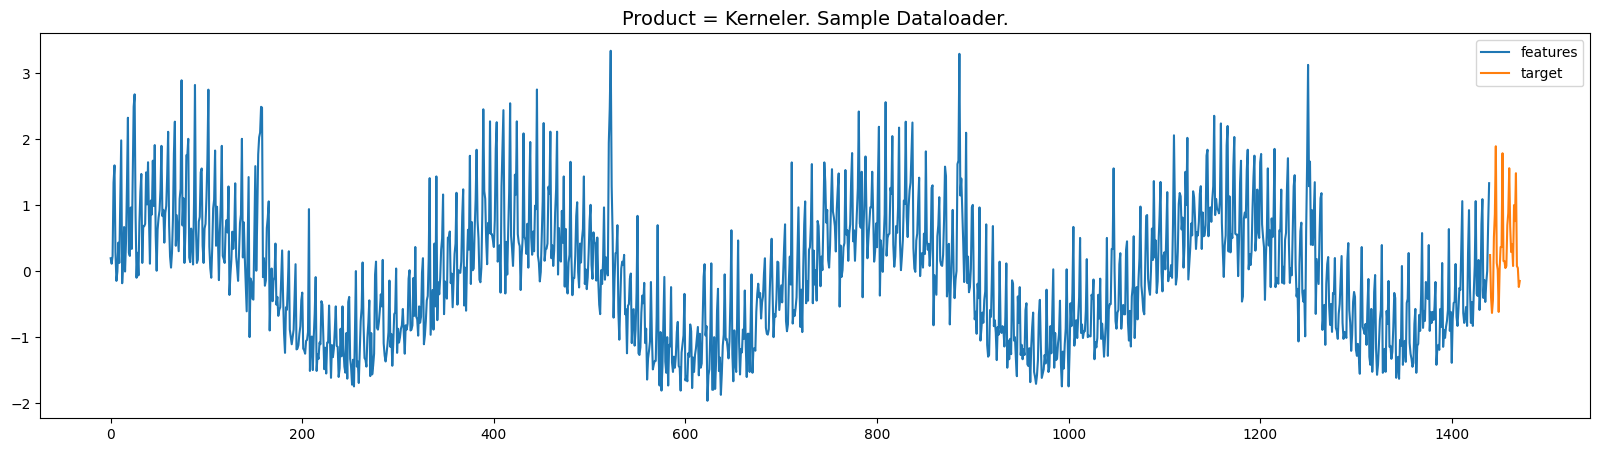

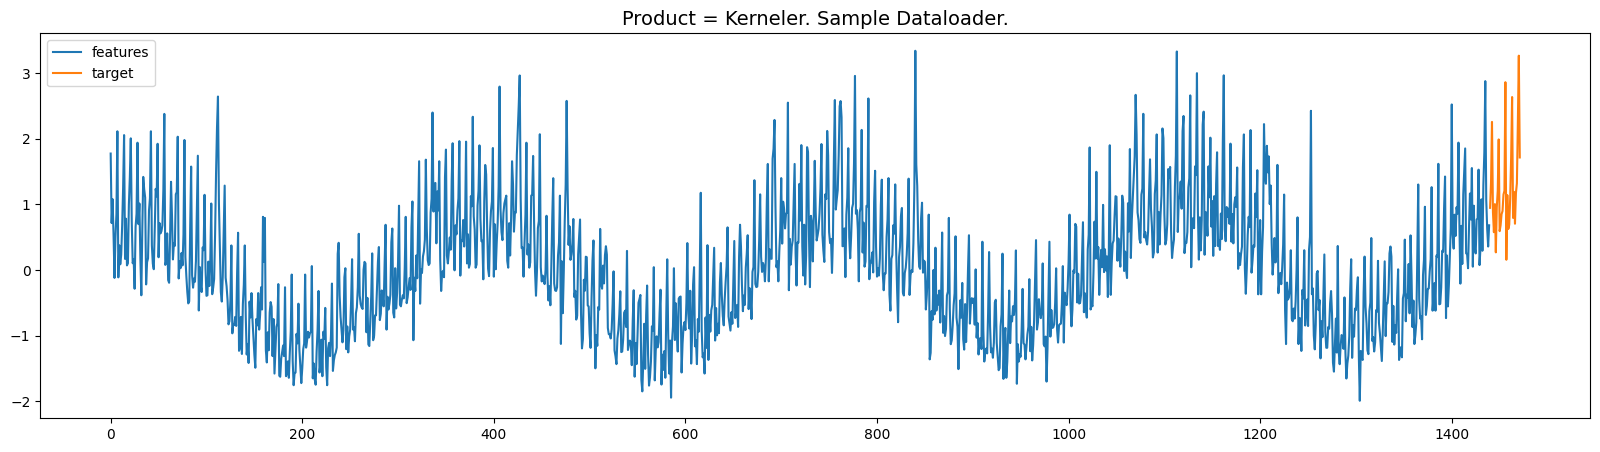

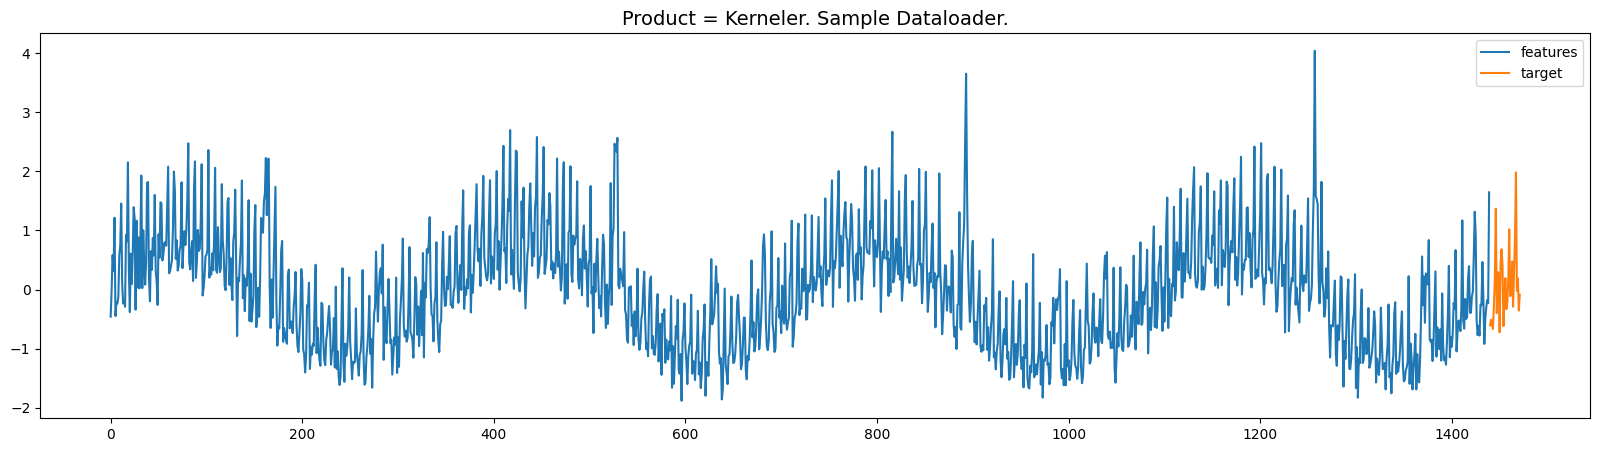

In [ ]:
# DISPLAY DATA LOADER
gen = DataGenerator(data, shuffle=False, f_length=LEN, product=PROD)
for x,y in gen:
    for k in range(4):
        plt.figure(figsize=(20,5))
        LN = x.shape[1]
        LN2 = y.shape[1]
        plt.plot(np.arange(LN),x[k,:,0],label='features')
        plt.plot(np.arange(LN2)+LN,y[k,:],label='target')
        plt.legend()
        plt.title(f"Product = {P[PROD]}. Sample Dataloader.",size=14)
        plt.show()
    break

Learning rate schedule: 0.001 to 0.001 to 1e-06


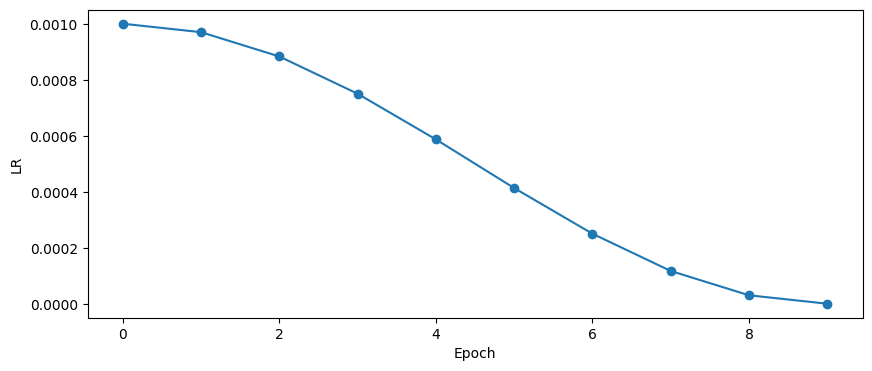

In [ ]:
import math, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 10

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [35]:
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version",tf.__version__)

Tensorflow version 2.18.0


In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class FANLayer(Layer):
    """
    FANLayer: The layer used in FAN (https://arxiv.org/abs/2410.02675).
    
    Args:
        input_dim (int): The number of input features.
        output_dim (int): The number of output features.
        p_ratio (float): The ratio of output dimensions used for cosine and sine parts (default: 0.25).
        activation (str or callable): The activation function to apply to the g component (default: 'gelu').
        use_p_bias (bool): If True, include bias in the linear transformations of p component (default: True).
    """
    
    def __init__(self, input_dim, output_dim, p_ratio=0.25, activation='gelu', use_p_bias=True, **kwargs):
        super(FANLayer, self).__init__(**kwargs)
        
        assert 0 < p_ratio < 0.5, "p_ratio must be between 0 and 0.5"
        
        self.p_ratio = p_ratio
        self.p_output_dim = int(output_dim * self.p_ratio)
        self.g_output_dim = output_dim - self.p_output_dim * 2  # Account for cosine and sine terms

        # Linear transformation for the p component (for cosine and sine parts)
        self.input_linear_p = Dense(self.p_output_dim, use_bias=use_p_bias)
        
        # Linear transformation for the g component
        self.input_linear_g = Dense(self.g_output_dim)
        
        # Set the activation function
        if activation == 'gelu':
            self.activation = tf.keras.activations.gelu
        else:
            self.activation = tf.keras.activations.get(activation)

    def call(self, src):
        """
        Args:
            src (Tensor): Input tensor of shape (batch_size, input_dim).
        
        Returns:
            Tensor: Output tensor of shape (batch_size, output_dim), after applying the FAN layer.
        """
        
        # Apply the linear transformation followed by the activation for the g component
        g = self.activation(self.input_linear_g(src))
        
        # Apply the linear transformation for the p component
        p = self.input_linear_p(src)
        
        # Concatenate cos(p), sin(p), and activated g along the last dimension
        output = tf.concat([tf.cos(p), tf.sin(p), g], axis=-1)
        
        return output

In [37]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate, LayerNormalization, Dropout
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, dropout_rate=0.1, num_fan_layers=2):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential()
        for _ in range(num_fan_layers):
            self.ffn.add(FANLayer(feat_dim, ff_dim))
            self.ffn.add(Dense(feat_dim))  # Optional: Add a Dense layer after each FANLayer
            self.ffn.add(Dropout(dropout_rate))  # Optional: Add dropout for regularization
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [38]:
def positional_encoding(maxlen, num_hid):
        depth = num_hid/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1)
        return pos_encoding

In [39]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

In [40]:
feat_dim = 16 
embed_dim = 32  
num_heads = 4  
ff_dim = 64
dropout_rate = 0.0
num_blocks = 3

def build_model():
    # INPUT 
    inp = tf.keras.Input(shape=(LEN, 2))
    
    # POSITIONAL ENCODING
    x = layers.Dense(feat_dim)(inp)
    p = positional_encoding(1440, feat_dim)
    x = x + p
    
    # THREE BLOCKS of WAVENET and TRANSFORMER
    for k in range(num_blocks):
        skip = x
        x = wave_block(x, feat_dim, 3, 12)
        x = wave_block(x, feat_dim, 3, 12)
        x = TransformerBlock(embed_dim, feat_dim, num_heads, ff_dim, dropout_rate, num_fan_layers=2)(x)
        x = 0.9 * x + 0.1 * skip 

    # HEAD
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='linear', dtype='float32')(x)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=loss, optimizer=opt)
    
    return model

In [41]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

TensorFlow version = 2.18.0
Using 1 GPU


In [42]:
# USE MIXED PRECISION
from tensorflow.keras.mixed_precision import set_global_policy

policy = 'mixed_float16'
set_global_policy(policy)
print(f"Mixed precision policy set to: {policy}")

Mixed precision policy set to: mixed_float16


In [ ]:
os.makedirs(f'models_v{VER}', exist_ok=True)

train_gen = DataGenerator(data, shuffle=True, batch_size=32, f_length=LEN, product=PROD)
valid_gen = DataGenerator(data, shuffle=False, batch_size=64, f_length=LEN, product=PROD)

with strategy.scope():
    model = build_model()
if TRAIN_MODEL:
    model.fit(train_gen, verbose=1,
          validation_data = valid_gen,
          epochs=EPOCHS, callbacks = [LR])
    model.save_weights(f'models_v{VER}/model_v{VER}_p{PROD}.weights.h5')
else:
    model.load_weights(f'{PATH}model_v{VER}_p{PROD}.weights.h5')

/home/ahme0030/Python/FAN-MicroDoppler/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 377s 349ms/step - loss: 0.6030 - val_loss: 0.4134 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009698764640825614.
Epoch 2/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 356s 348ms/step - loss: 0.4037 - val_loss: 0.1841 - learning_rate: 9.6988e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008831391993379295.
Epoch 3/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 356s 347ms/step - loss: 0.1639 - val_loss: 0.1527 - learning_rate: 8.8314e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007502500000000002.
Epoch 4/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 356s 348ms/step - loss: 0.1519 - val_loss: 0.1490 - learning_rate: 7.5025e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0005872372647446319.
Epoch 5/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 355s 347ms/step - loss: 0.1488 - val_loss: 0.1468 - learning_rate: 5.8724e-04

Epoch 6: LearningRa

In [44]:
# ADD NAN INDICATOR FEATURE TO DATA
data = np.expand_dims(data,axis=-1)
nans = np.isnan(data).astype('float32')
data = np.concatenate([data,nans],axis=-1)

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


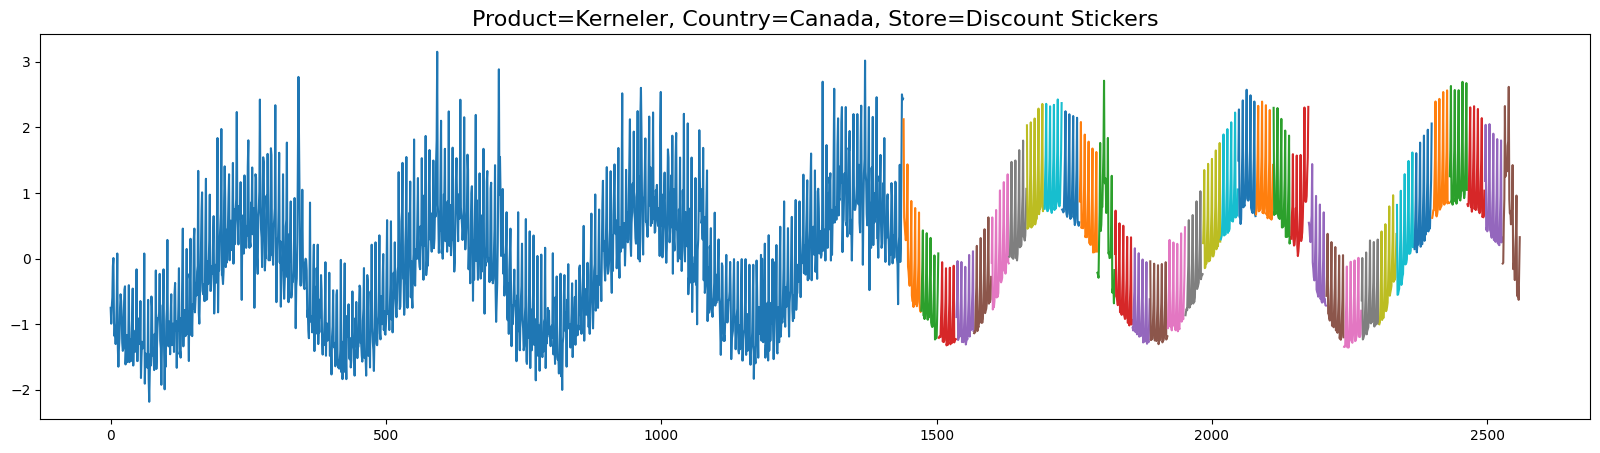

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


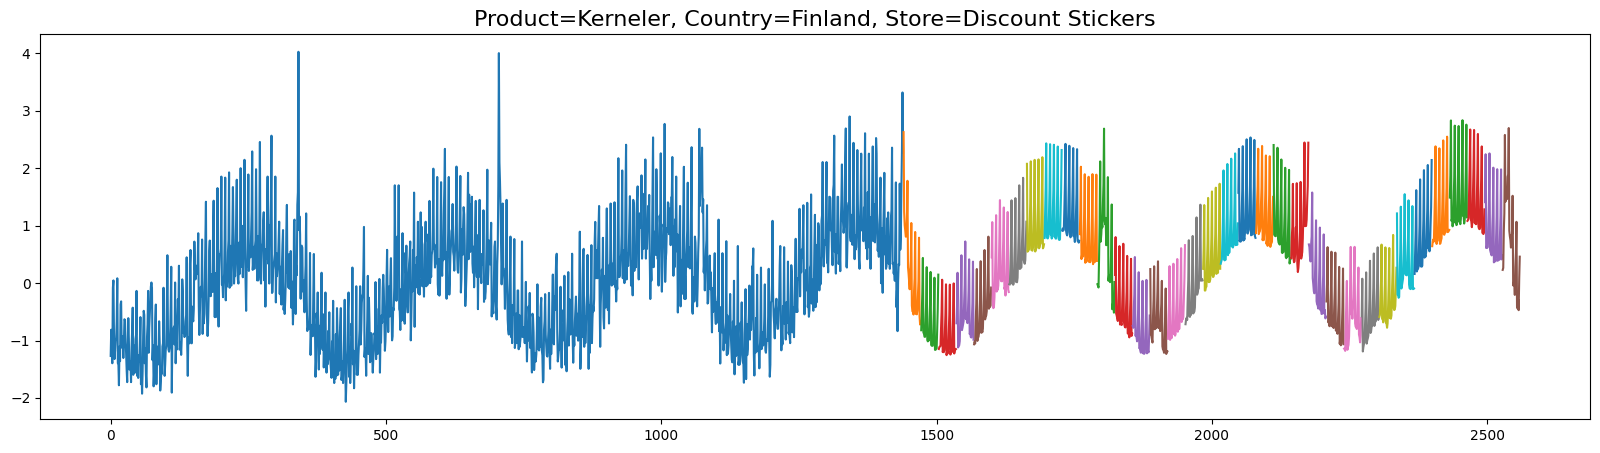

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


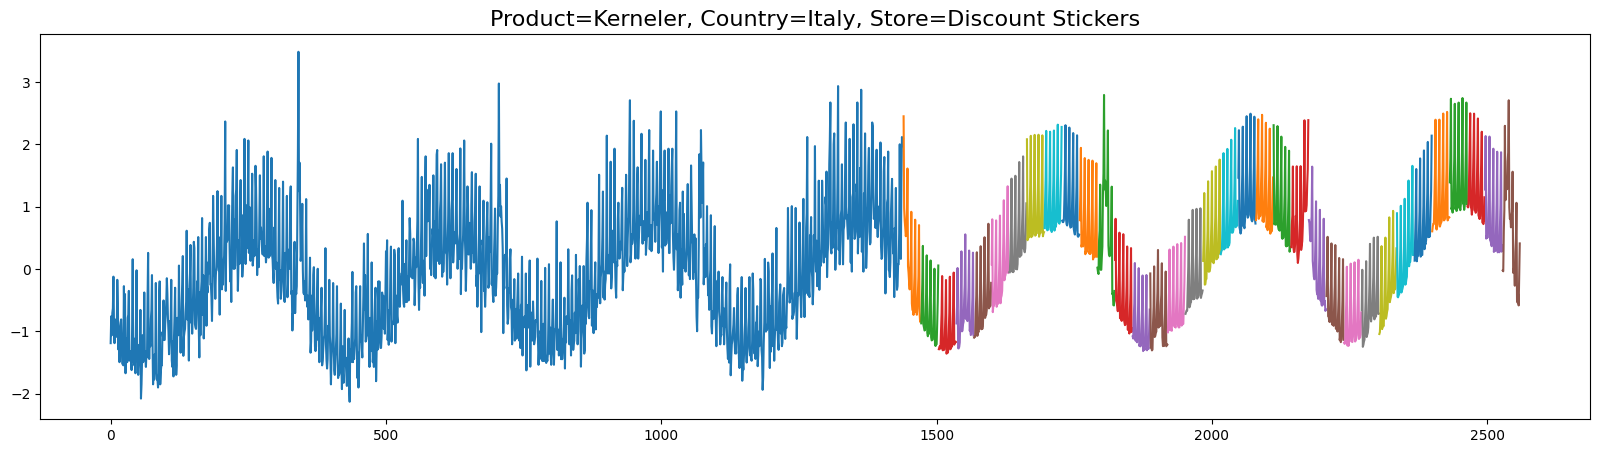

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


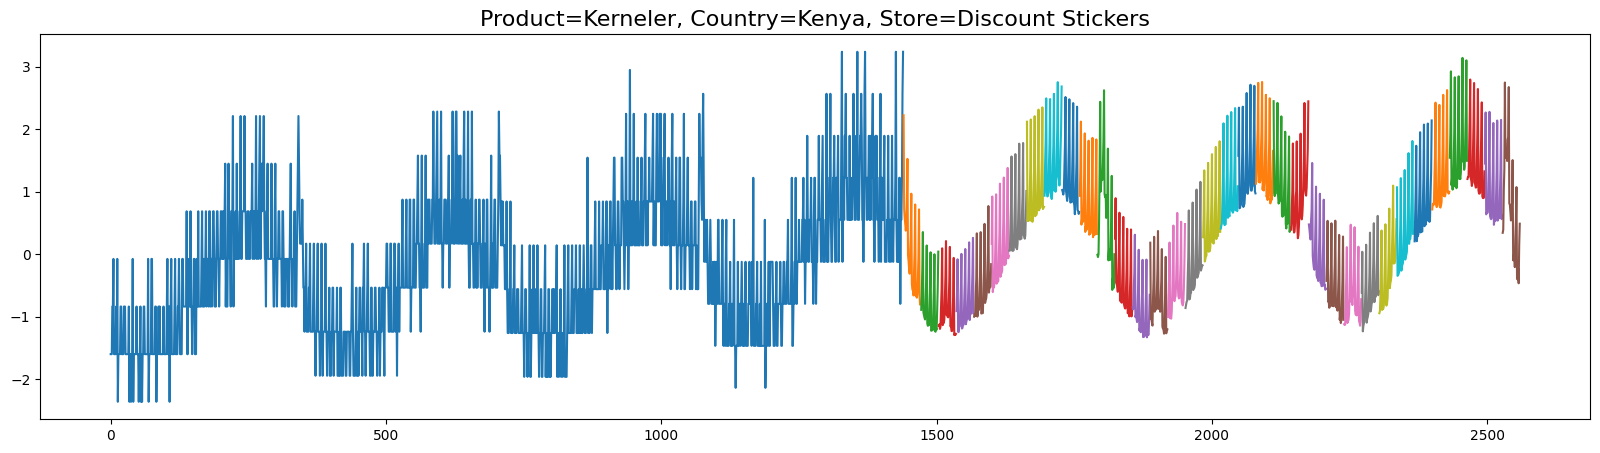

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


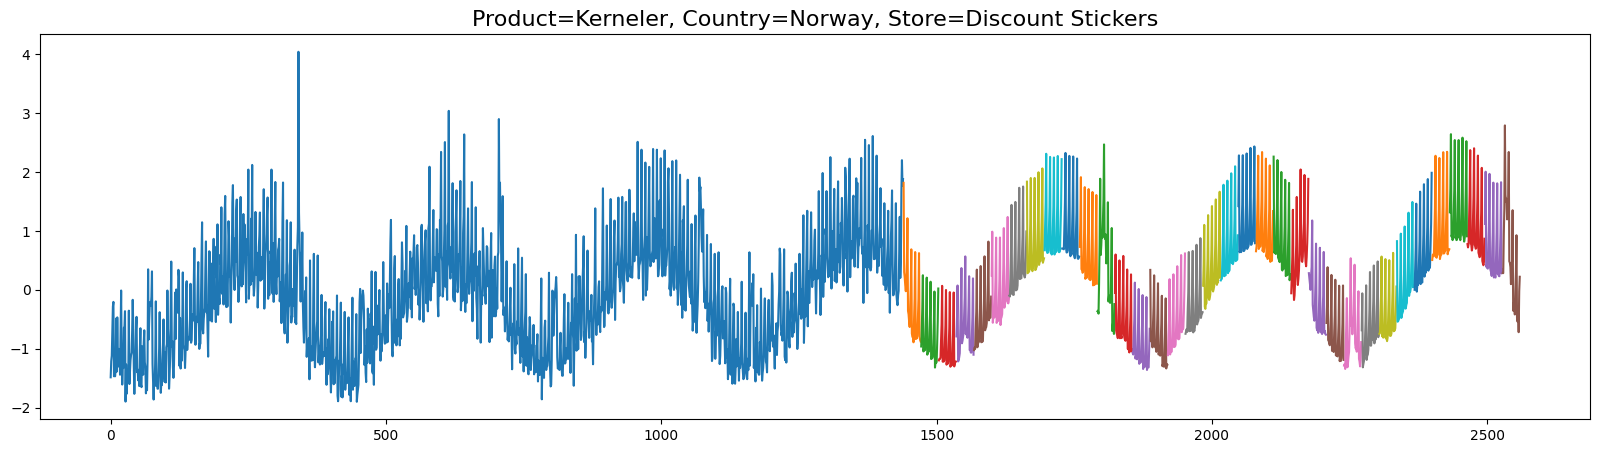

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


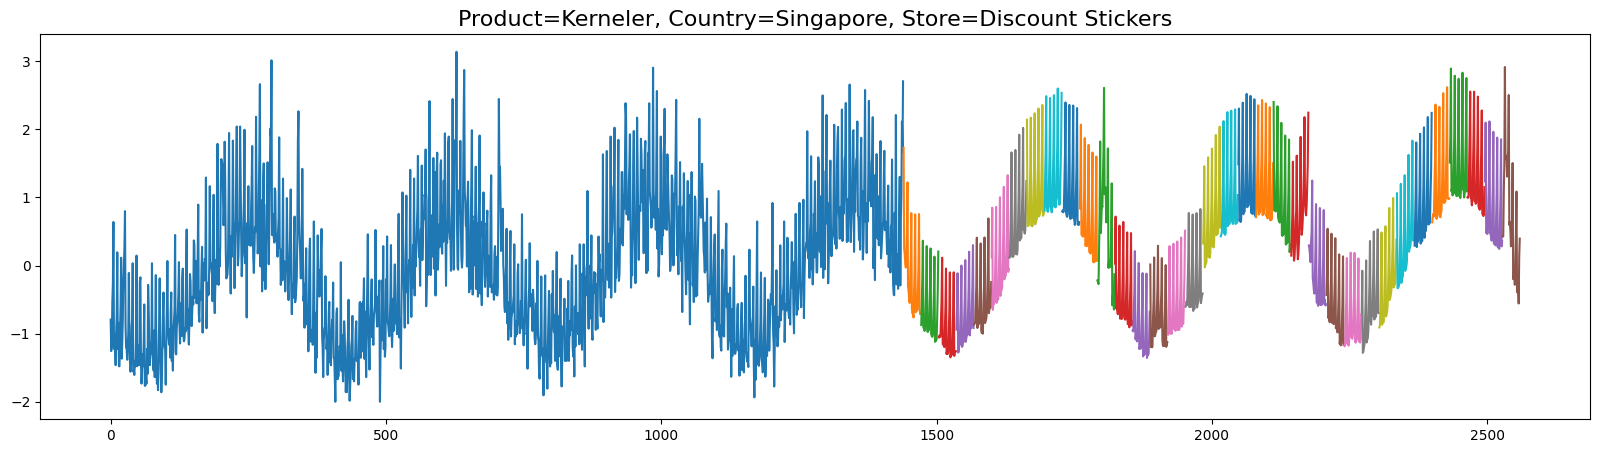

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


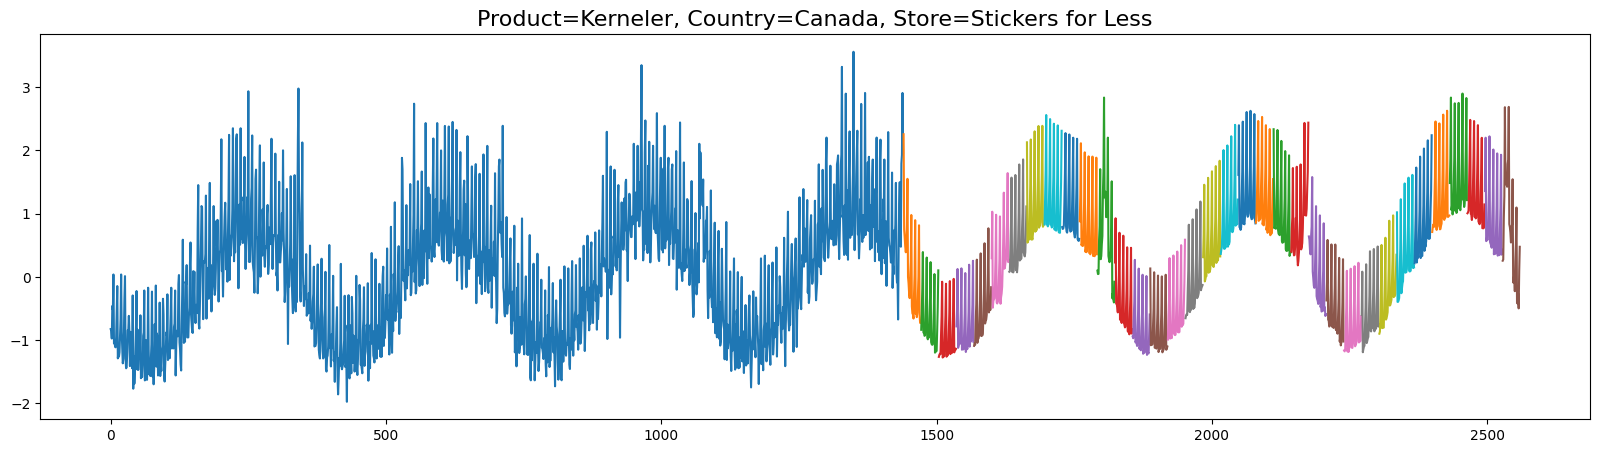

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


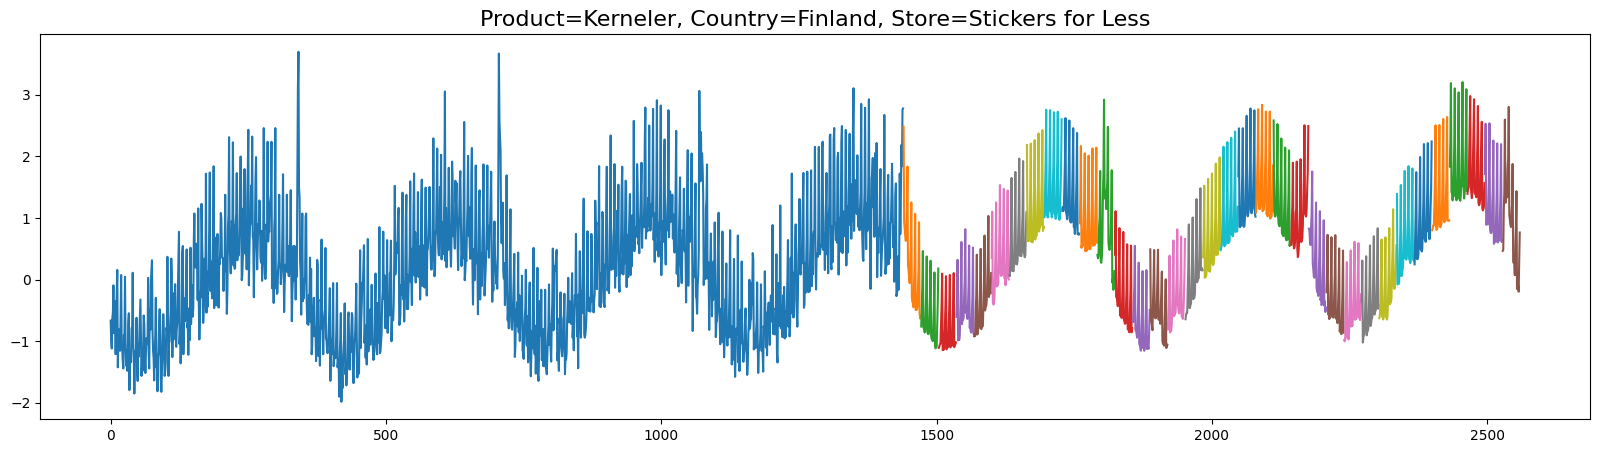

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


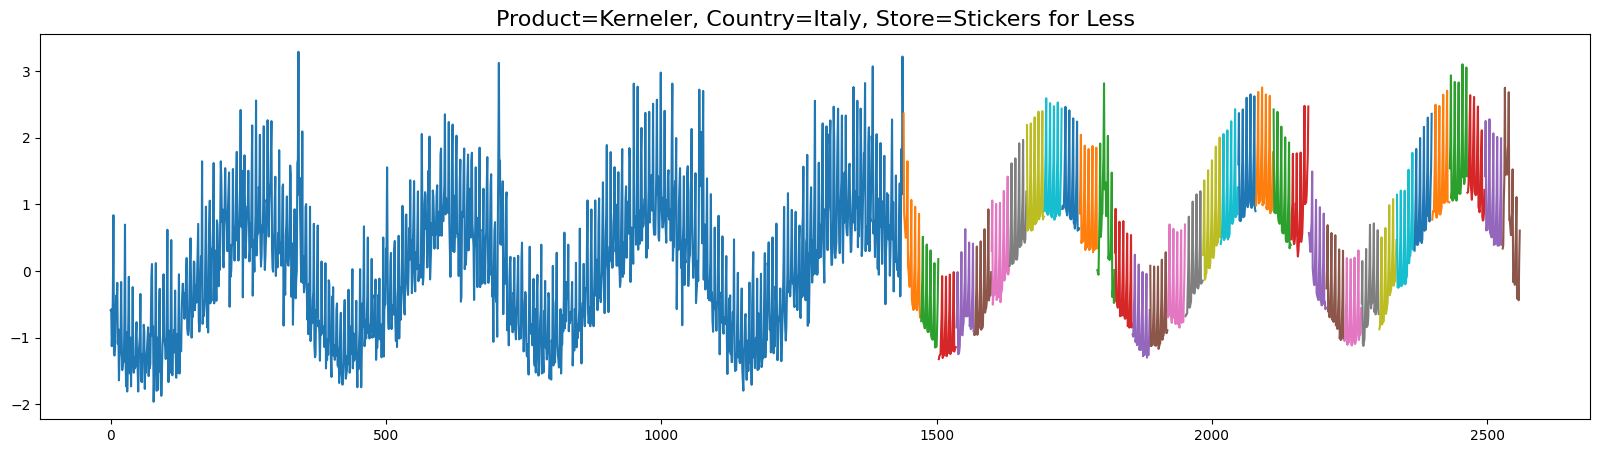

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 

2025-01-30 15:51:40.739228: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


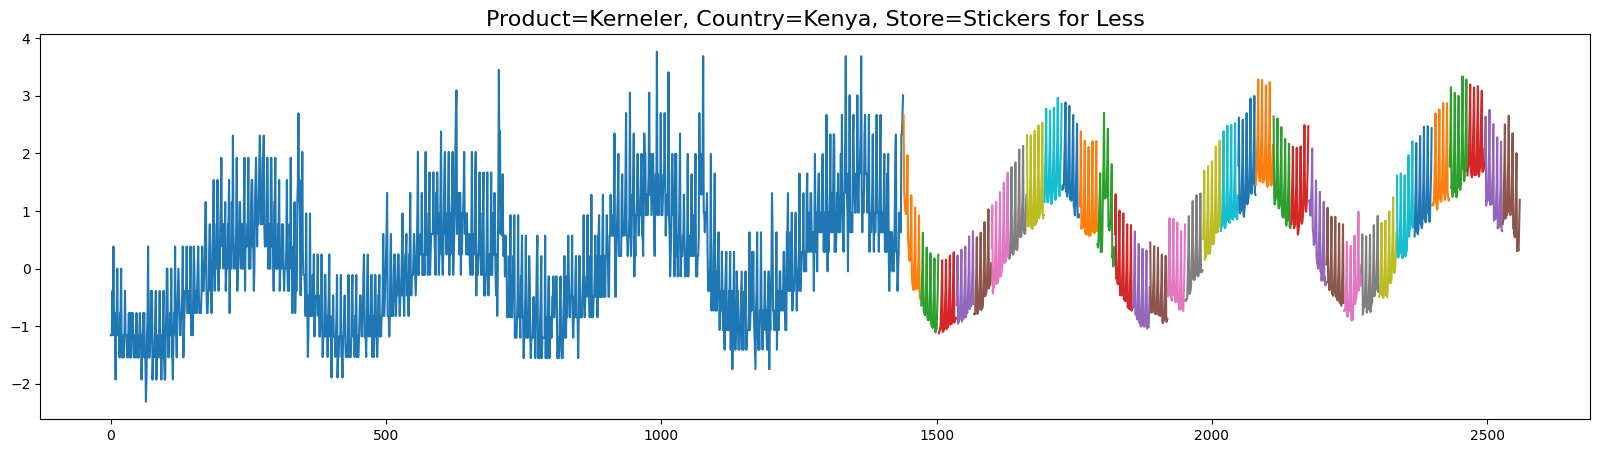

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


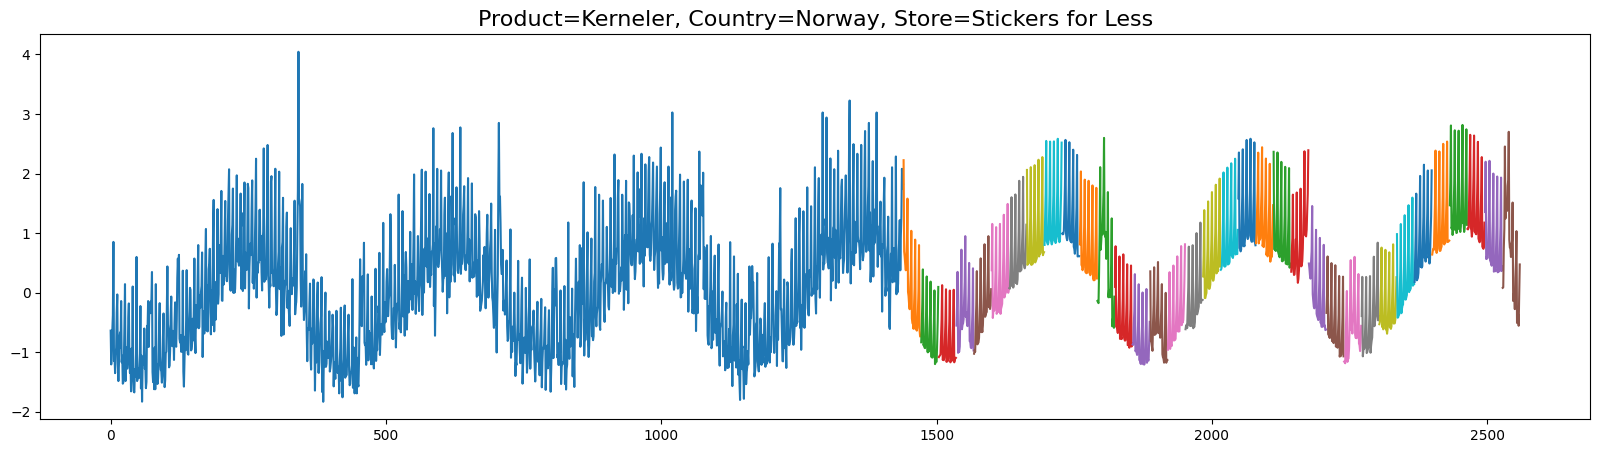

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


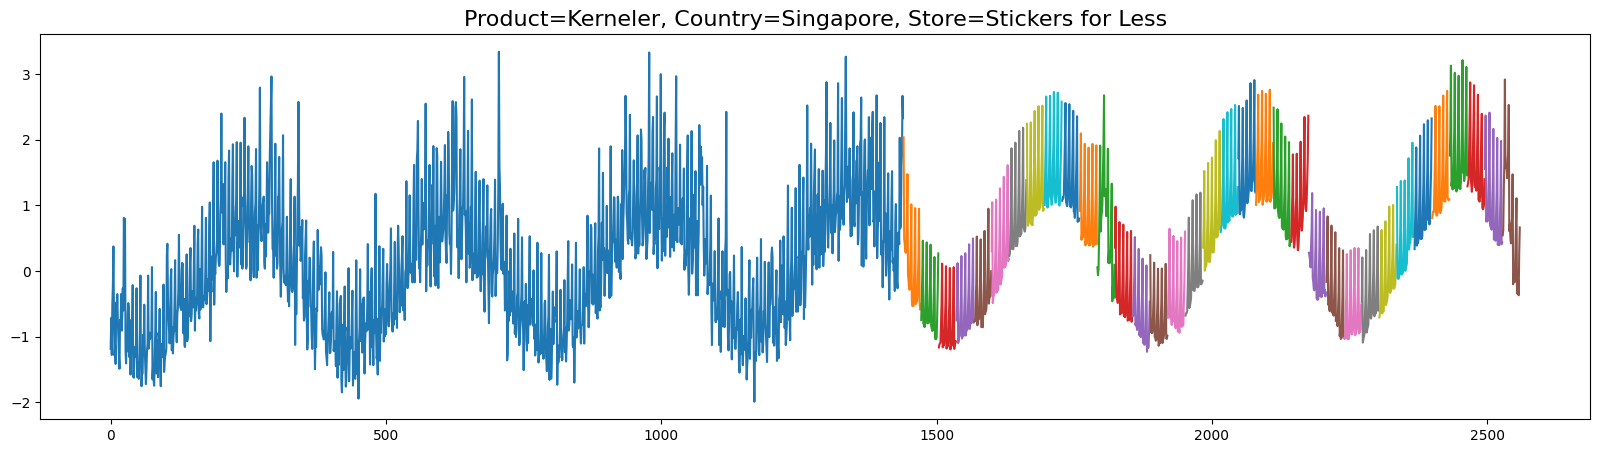

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


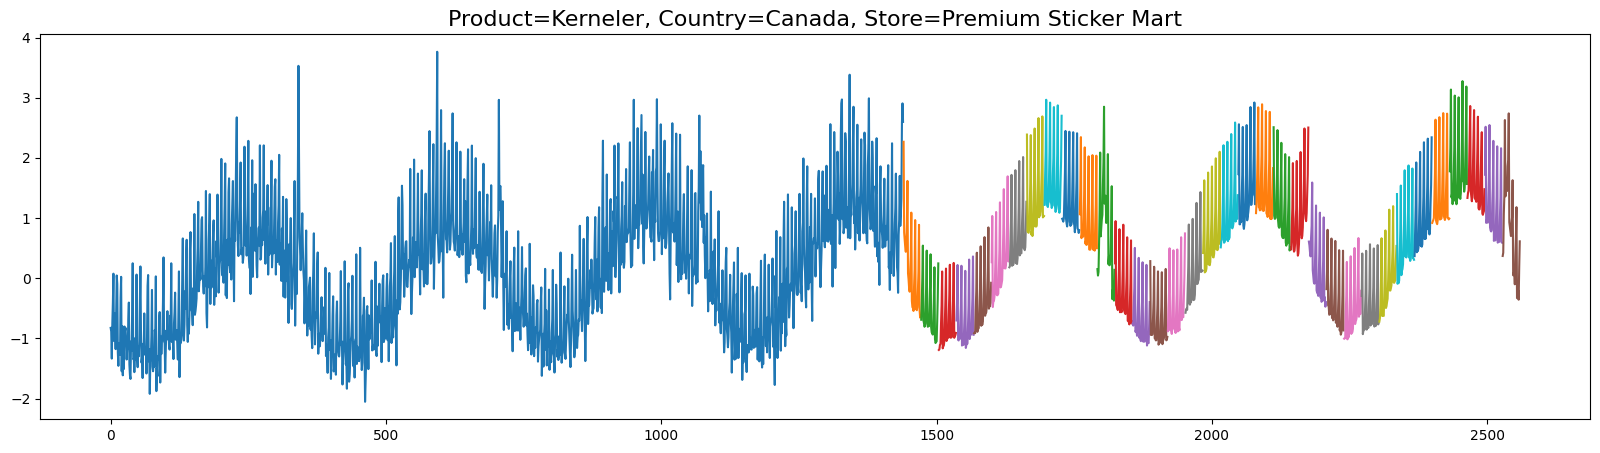

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


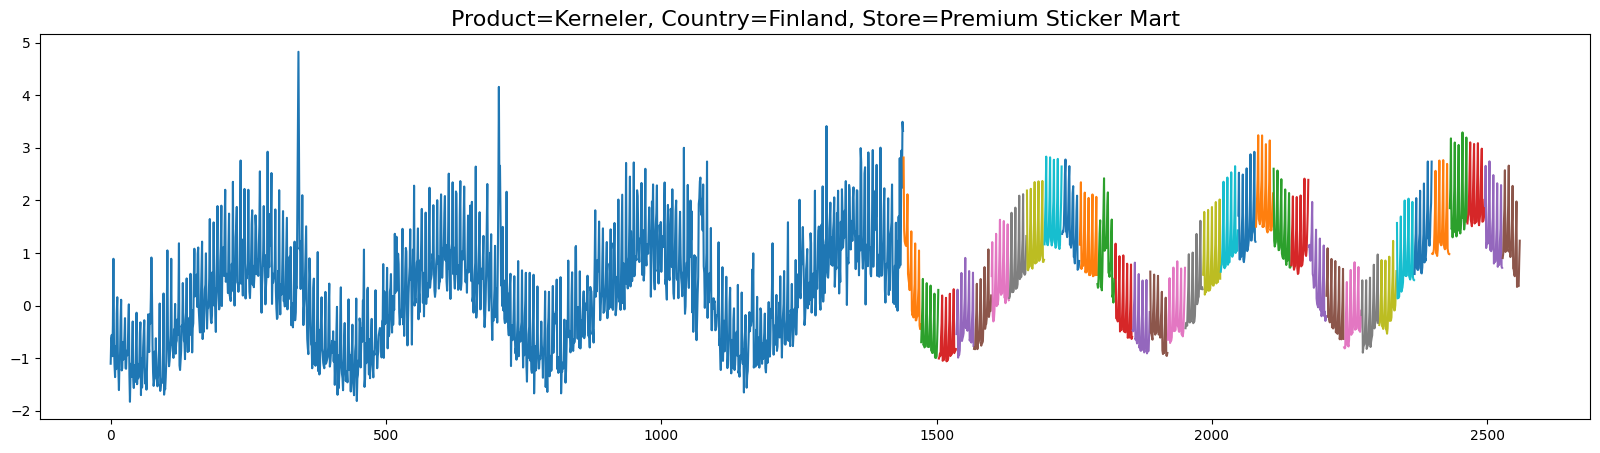

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


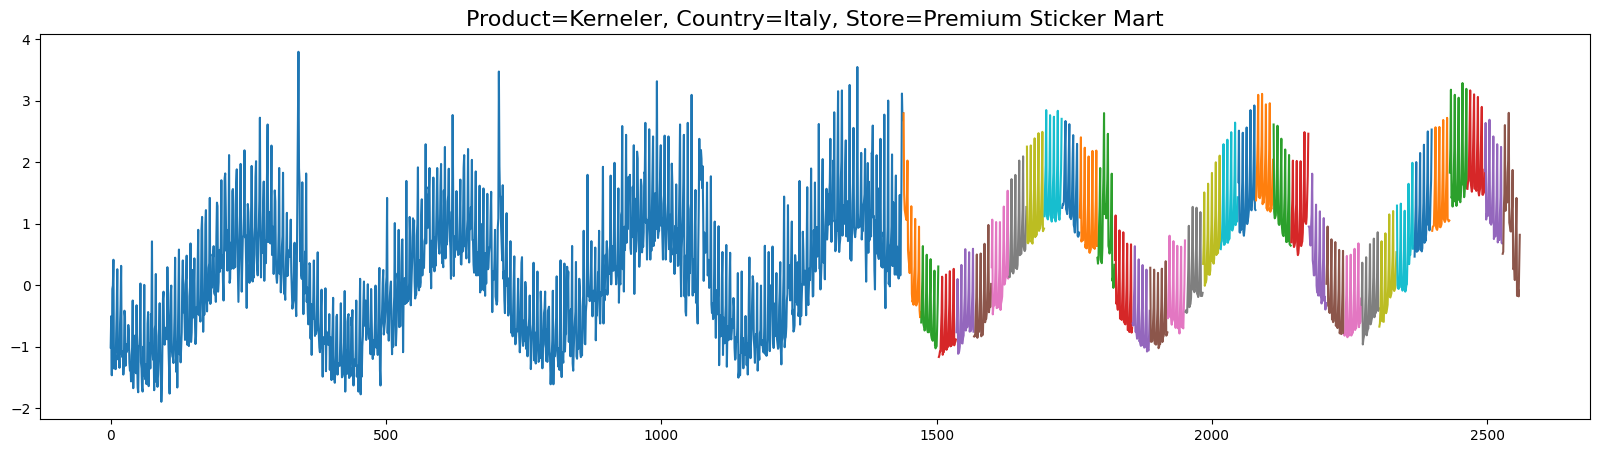

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


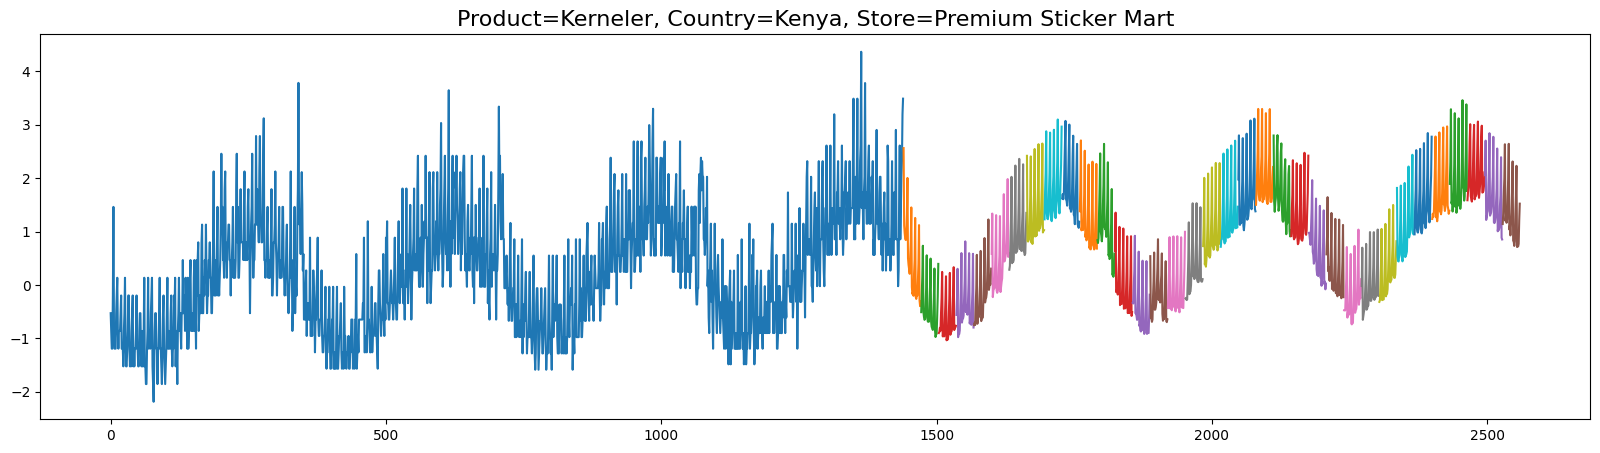

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


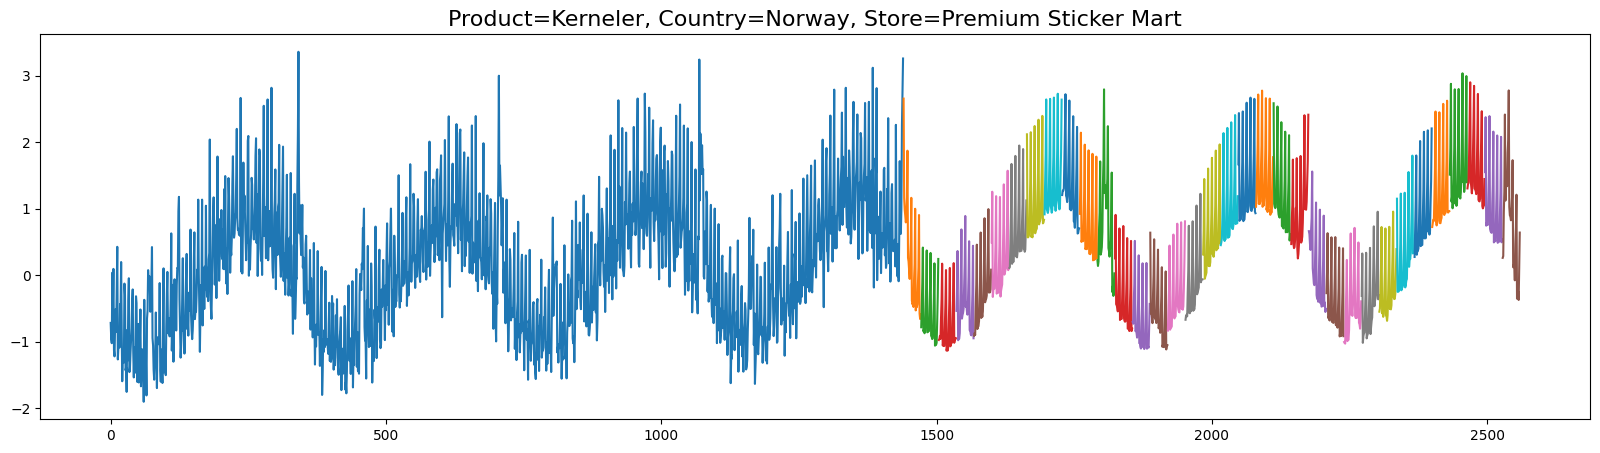

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


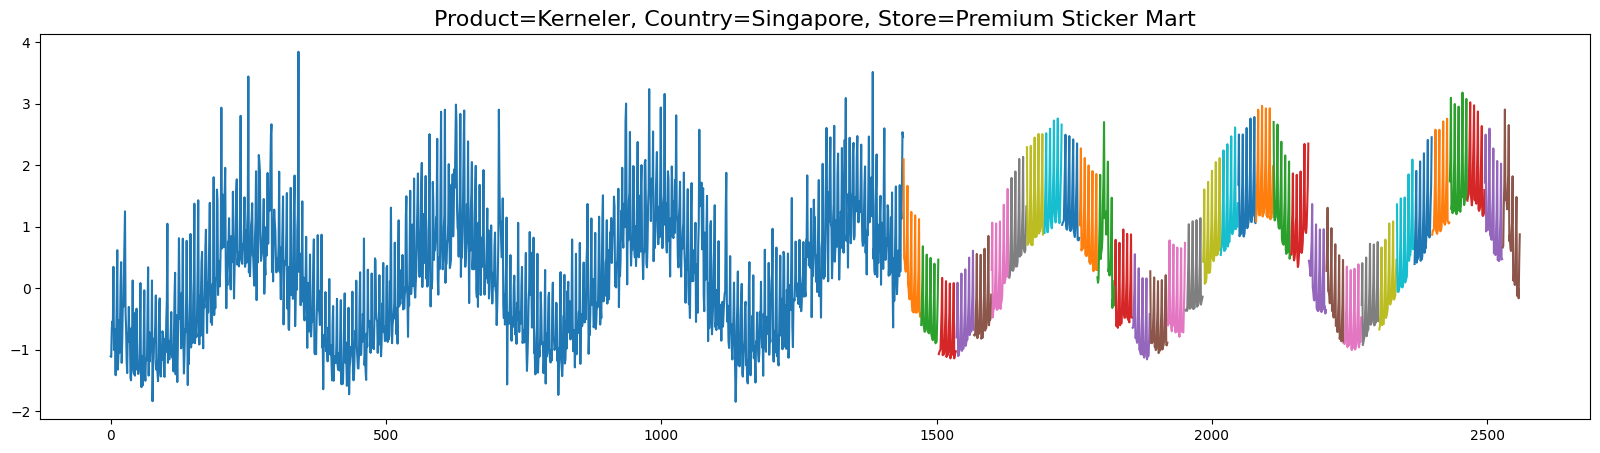

In [ ]:
preds = np.zeros((18,32*35))

# ITERATE OVER ALL COMBINATIONS OF COUNTRY AND STORE FOR SPECIFIC PRODUCT
# PREDICT 3 YEARS INTO THE FUTURE

bad_rows = []
for jj in range(18):
    ddd0 = data[PROD:PROD+1,-LEN:,jj,:].copy()
    if np.isnan(ddd0[:,:,0]).sum()==LEN:
        bad_rows.append(jj)
    
    pp = []
    for j in range(0,35):
        print(j,", ",end="")
        if j==0: dd2 = ddd0
        else: dd2 = np.concatenate([ddd0[:,32*j:,:]]+pp,axis=1) 
        p2 = model.predict( np.nan_to_num(dd2[:,-LEN:,:]) ,verbose=0)
        p2 = p2.reshape((1,32,1)) # ADD NAN INDICATOR TO PREDICTIONS
        p2 = np.concatenate([p2,np.zeros_like(p2)],axis=-1)
        pp.append(p2)
        if j==34:
            print()
            plt.figure(figsize=(20,5))
            plt.plot(np.arange(LEN), np.nan_to_num(ddd0[0,:,0]) )
            for k in range(j+1):
                plt.plot(np.arange(32)+LEN+32*k,pp[k][0,:,0])
            cc = C[jj%6]
            ss = S[jj//6]
            plt.title(f"Product={P[PROD]}, Country={cc}, Store={ss}",size=16)
            plt.show()
            
    preds[jj,:] = np.concatenate([z[:,:,:1] for z in pp],axis=1).flatten() 

In [46]:
# FILLNAN PREDS
FILLNAN = np.nanmean(preds,axis=0)
for r in bad_rows:
    preds[r,:] = FILLNAN

# REVERSE STANDARIZE PREDICTIONS AND FIX KENYA
preds = (preds*stds[PROD])+means[PROD]
for i in [3,9,15]: preds[i,:] = preds[i,:]/1.15

In [47]:
if PROD==0:
    test = pd.read_csv("playground-series-s5e1/test.csv")
    test.date = pd.to_datetime(test.date)
    test['alpha3'] = test['country'].map(dict(zip(
        np.sort(test['country'].unique()), alpha3s)))
    years = np.sort(test['date'].dt.year.unique())
    test['year'] = test['date'].dt.year
    if USE_INTERNET:
        gdp = np.array([
            [get_gdp_per_capita(alpha3, year) for year in years]
            for alpha3 in alpha3s
        ])
        gdp1 = pd.DataFrame(gdp, index=alpha3s, columns=years)
    else:
        gdp1 = pd.read_csv(f"{PATH}gdp1.csv")
        gdp1 = gdp1.set_index("Unnamed: 0")
        gdp1 = gdp1.rename(columns=lambda x: int(x))
    test['GDP'] = test.apply(lambda s: gdp1.loc[s['alpha3'], s['year']], axis=1)
    test["num_sold"] = 0.0
else:
    test = pd.read_csv(f"test_v{VER}_p{PROD-1}.csv")
    test.date = pd.to_datetime(test.date)

In [ ]:
for i in range(3):
    for j in range(6):
        test.loc[(test['product']==P[PROD])&(test.store==S[i])&(test.country==C[j]),'num_sold'] =\
            preds[i*6+j,:1095]
test["store_ratio"] = test.store.map(store_ratio)
test.loc[test['product']==P[PROD],"num_sold"] =\
    test.loc[test['product']==P[PROD],"num_sold"] * test.loc[test['product']==P[PROD],"GDP"]
test.loc[test['product']==P[PROD],"num_sold"] =\
    test.loc[test['product']==P[PROD],"num_sold"] * test.loc[test['product']==P[PROD],"store_ratio"]

print( test.shape )
display( test.head() )

(98550, 10)


id       date country              store             product alpha3  \
0  230130 2017-01-01  Canada  Discount Stickers   Holographic Goose    CAN   
1  230131 2017-01-01  Canada  Discount Stickers              Kaggle    CAN   
2  230132 2017-01-01  Canada  Discount Stickers        Kaggle Tiers    CAN   
3  230133 2017-01-01  Canada  Discount Stickers            Kerneler    CAN   
4  230134 2017-01-01  Canada  Discount Stickers  Kerneler Dark Mode    CAN   

   year           GDP    num_sold  store_ratio  
0  2017  45129.628117  135.984472     0.008957  
1  2017  45129.628117  863.719743     0.008957  
2  2017  45129.628117  659.514704     0.008957  
3  2017  45129.628117  412.032204     0.008957  
4  2017  45129.628117    0.000000     0.008957

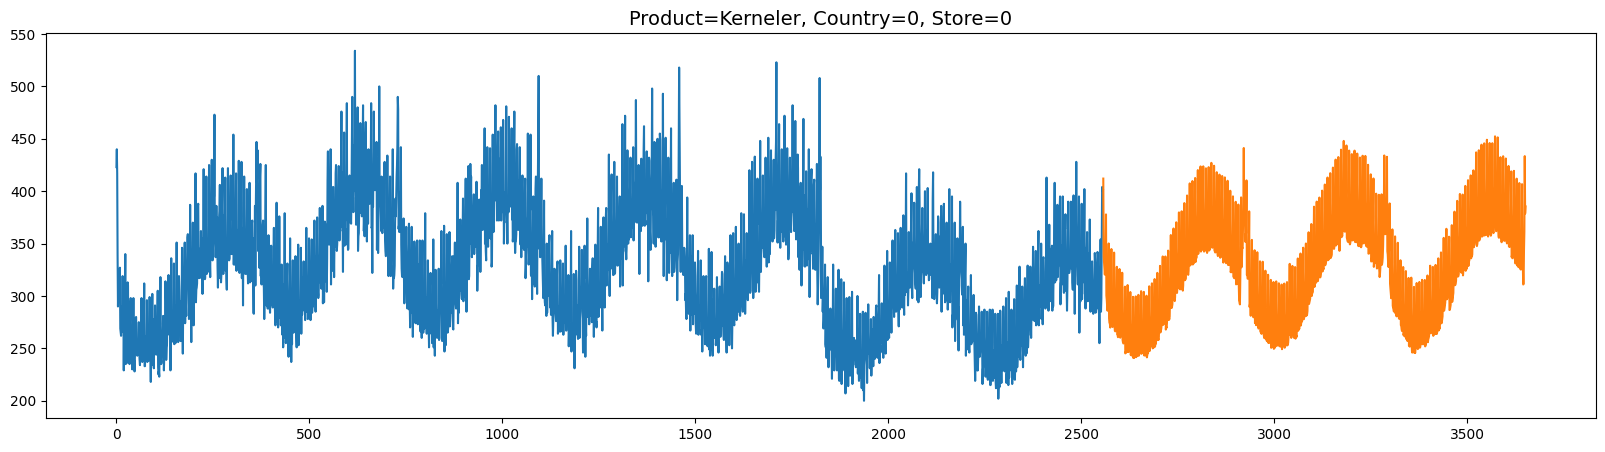

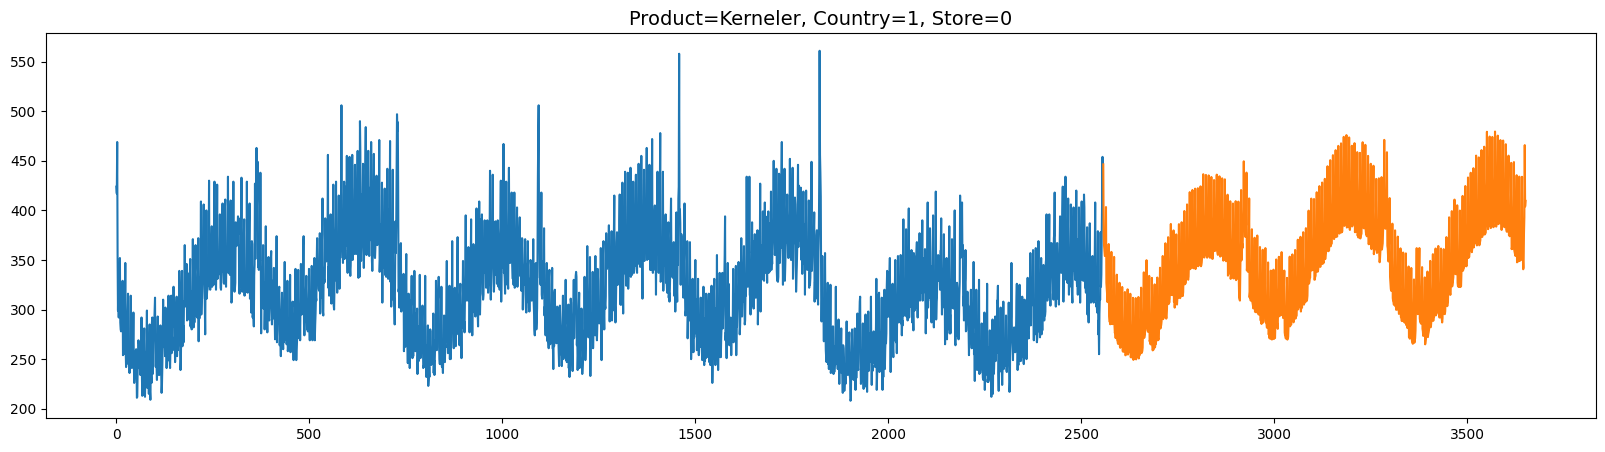

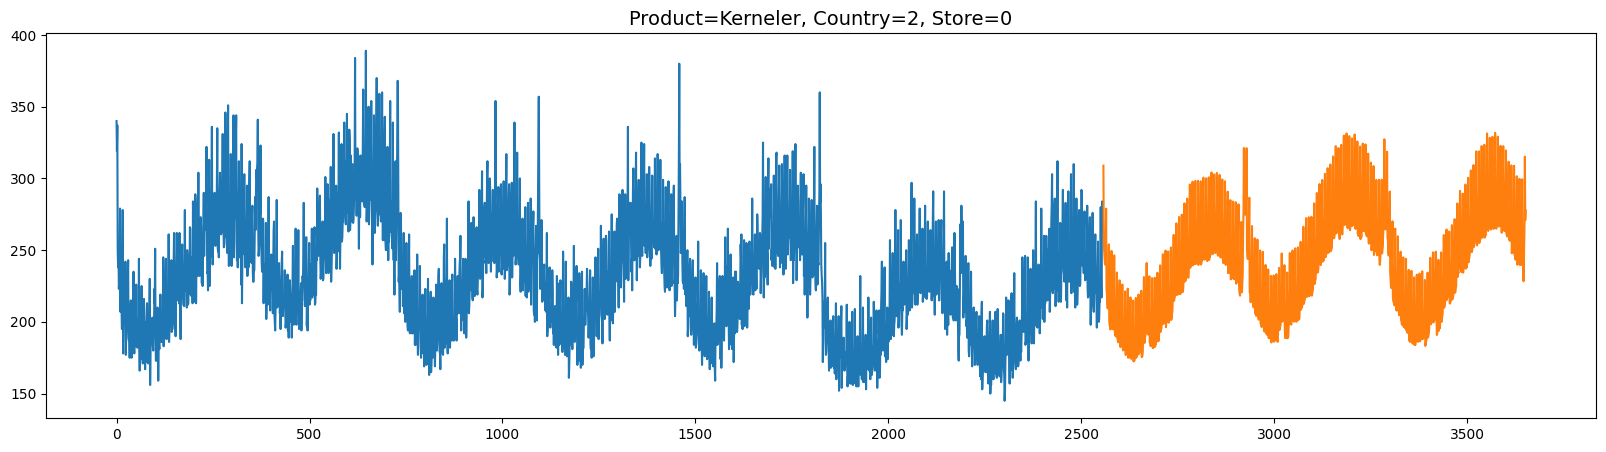

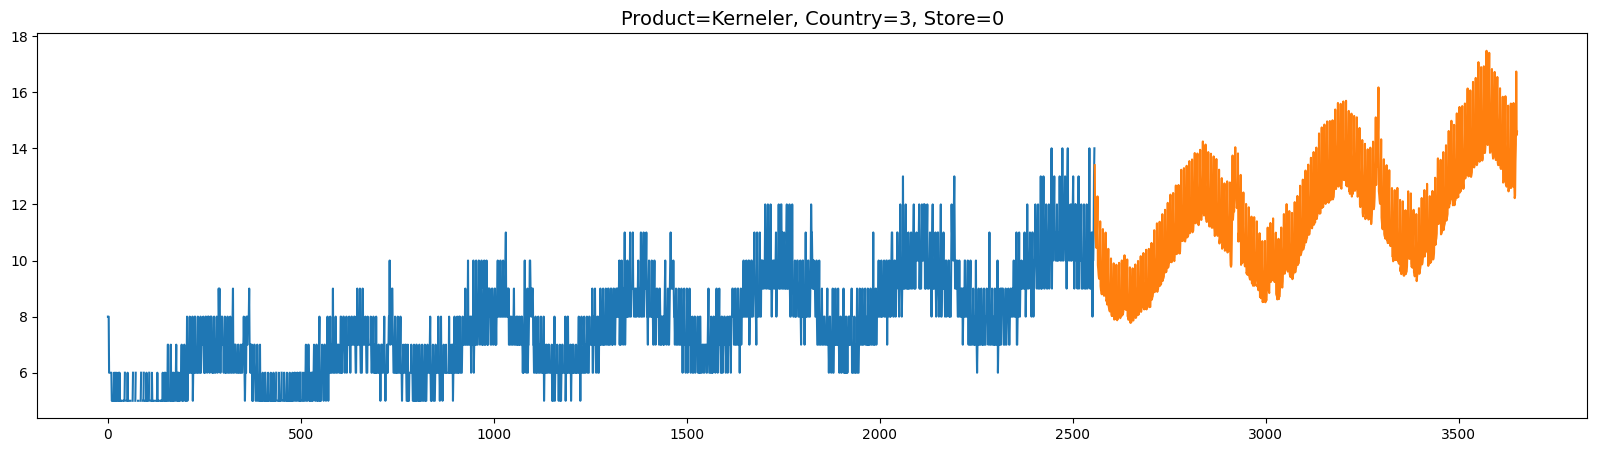

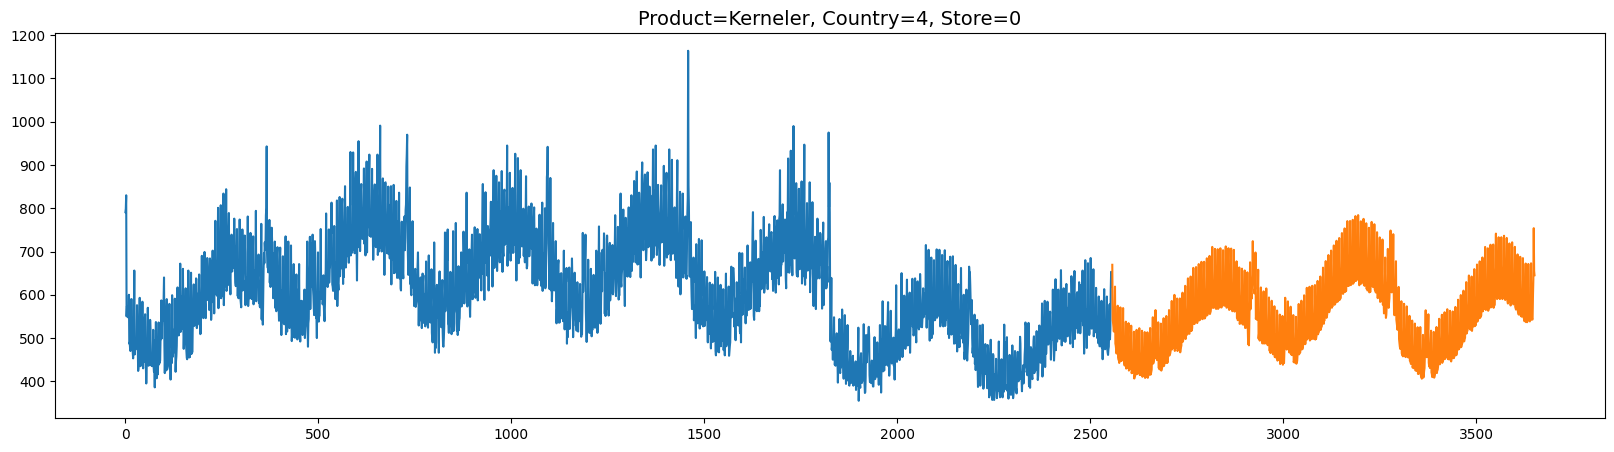

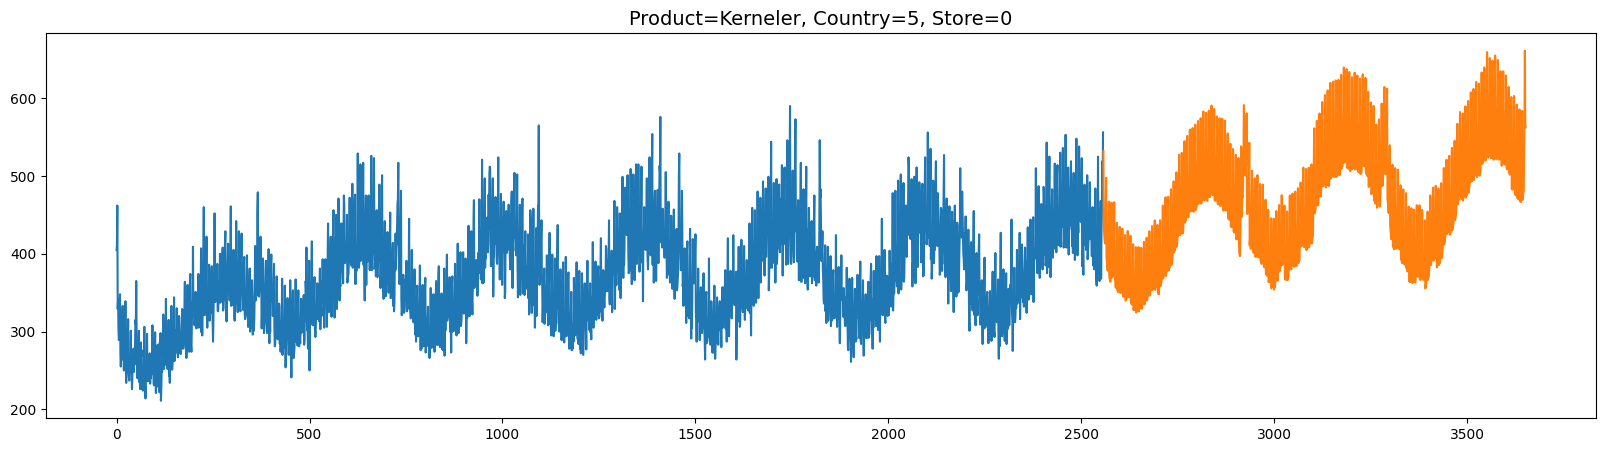

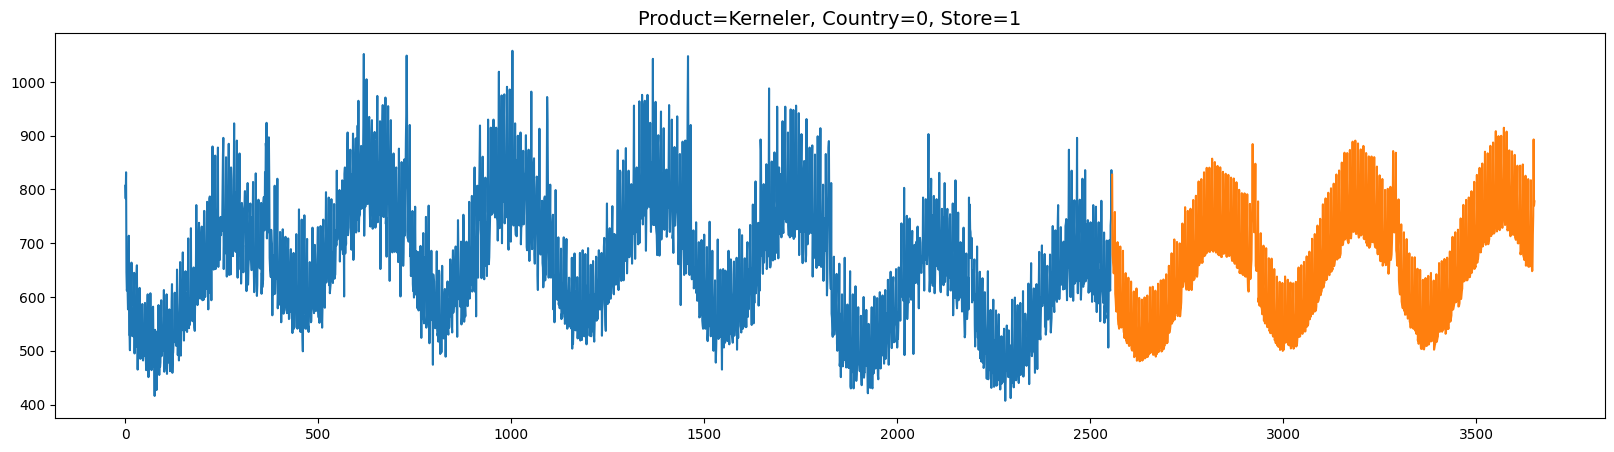

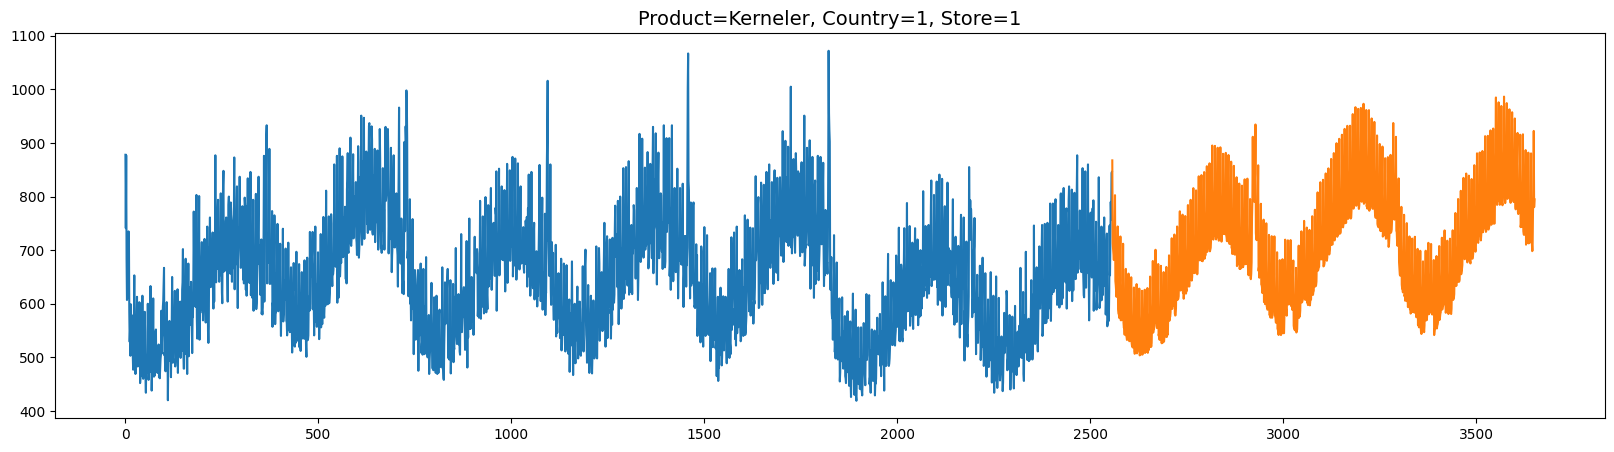

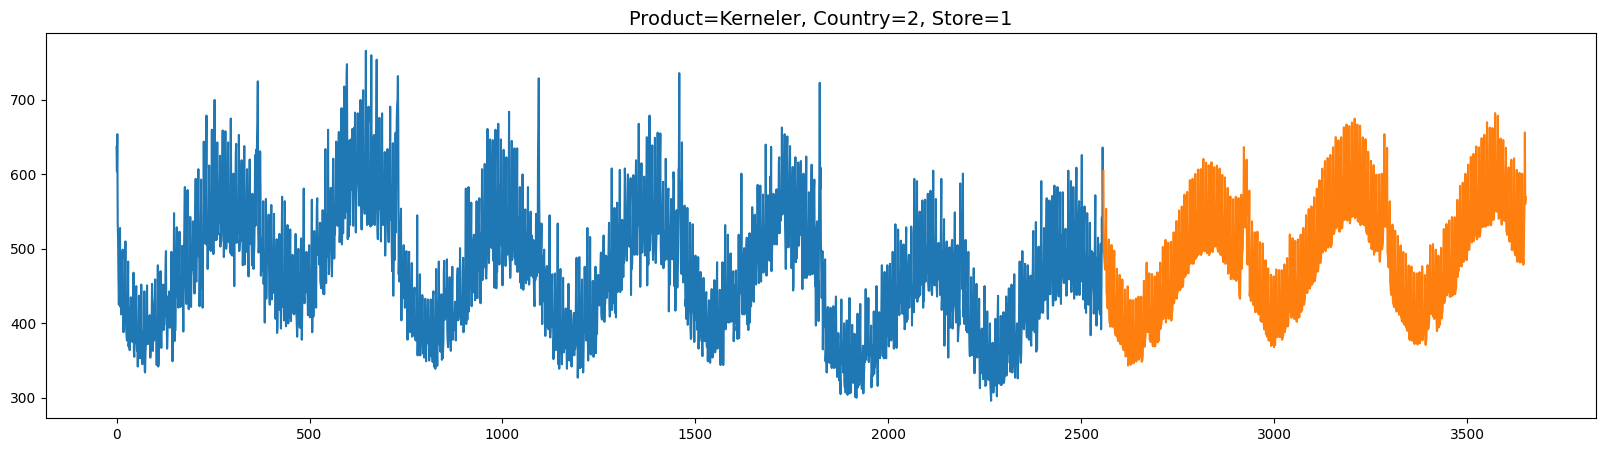

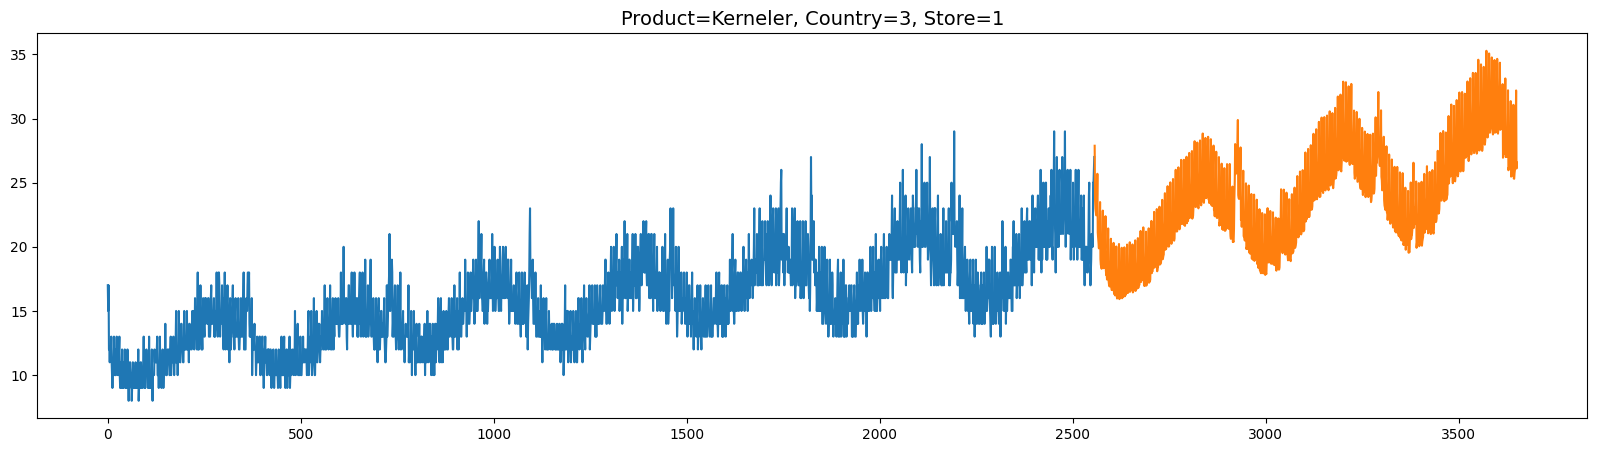

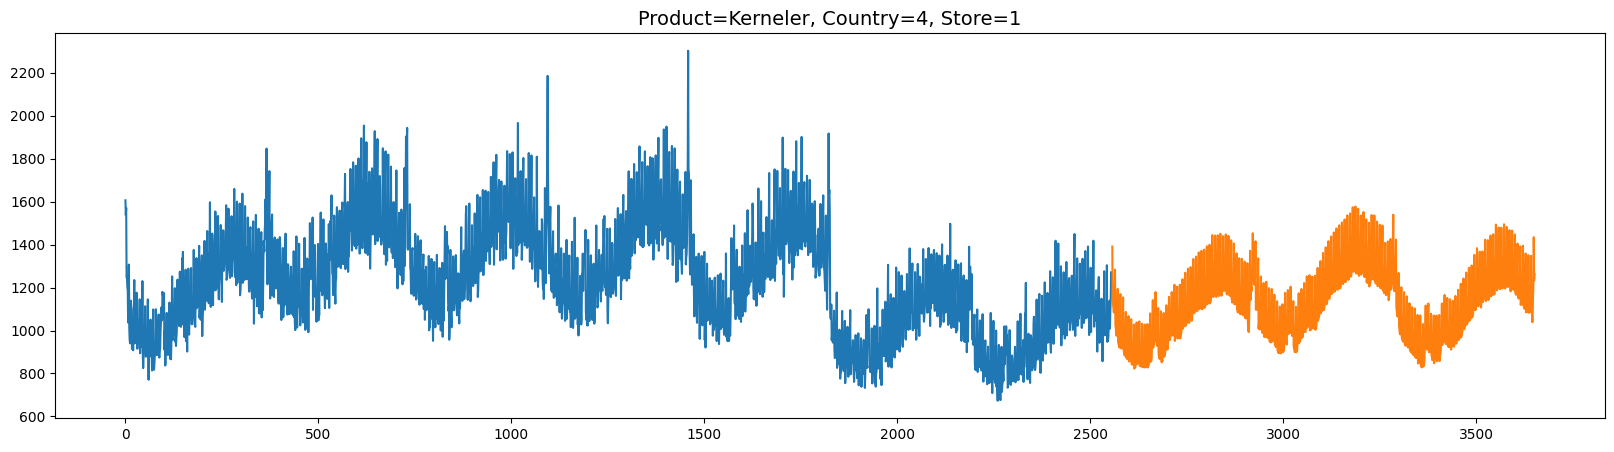

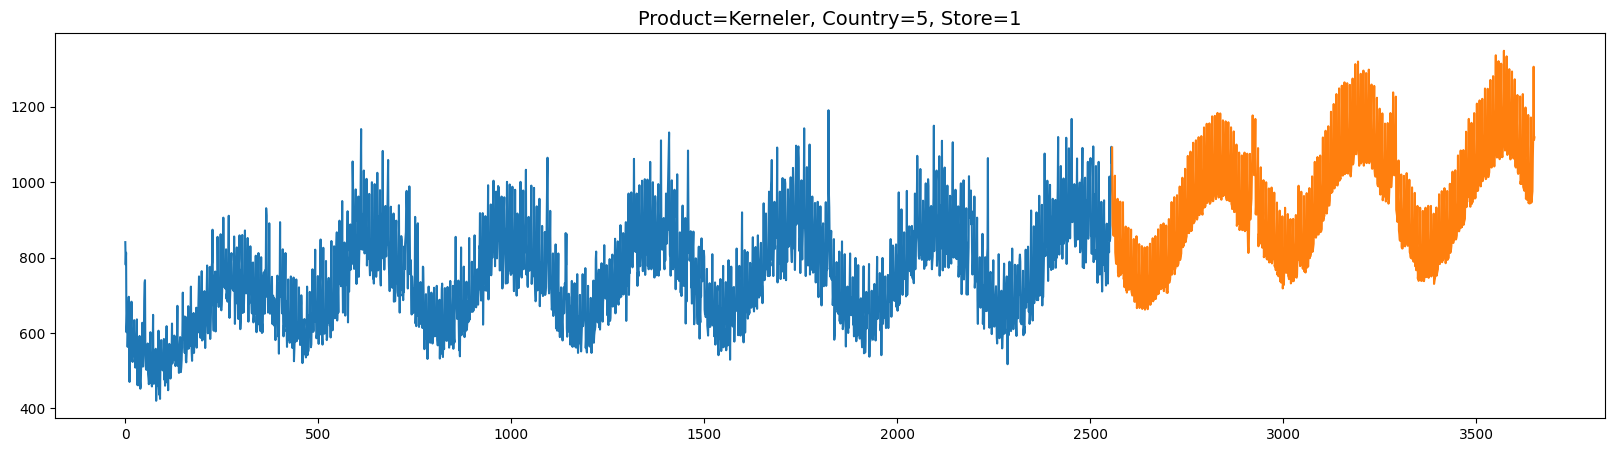

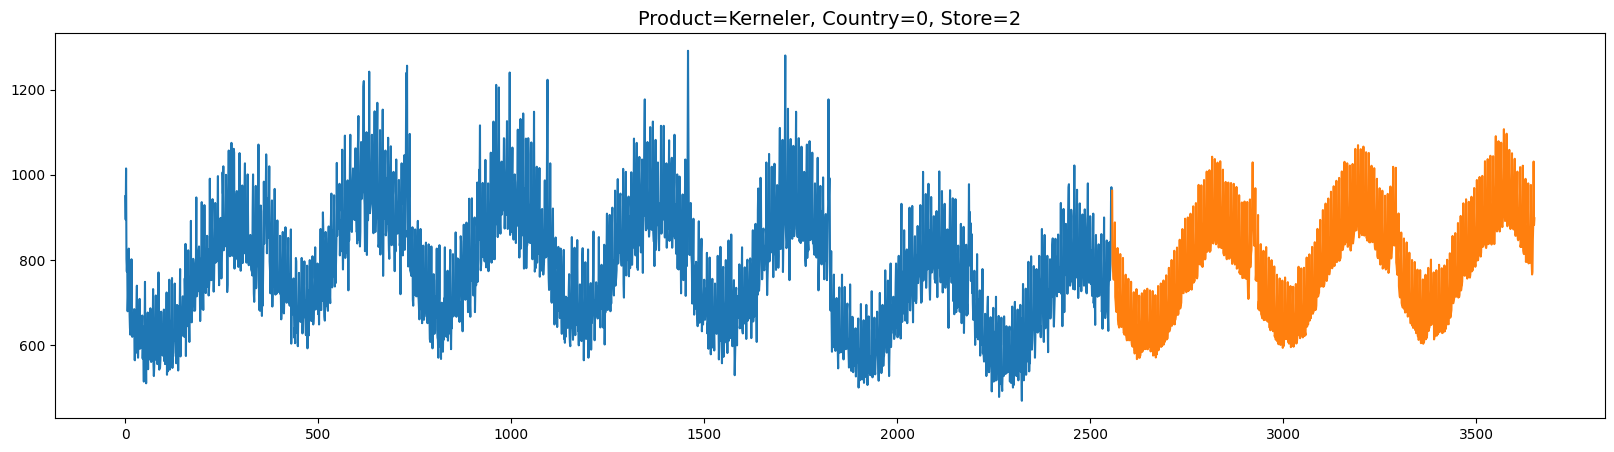

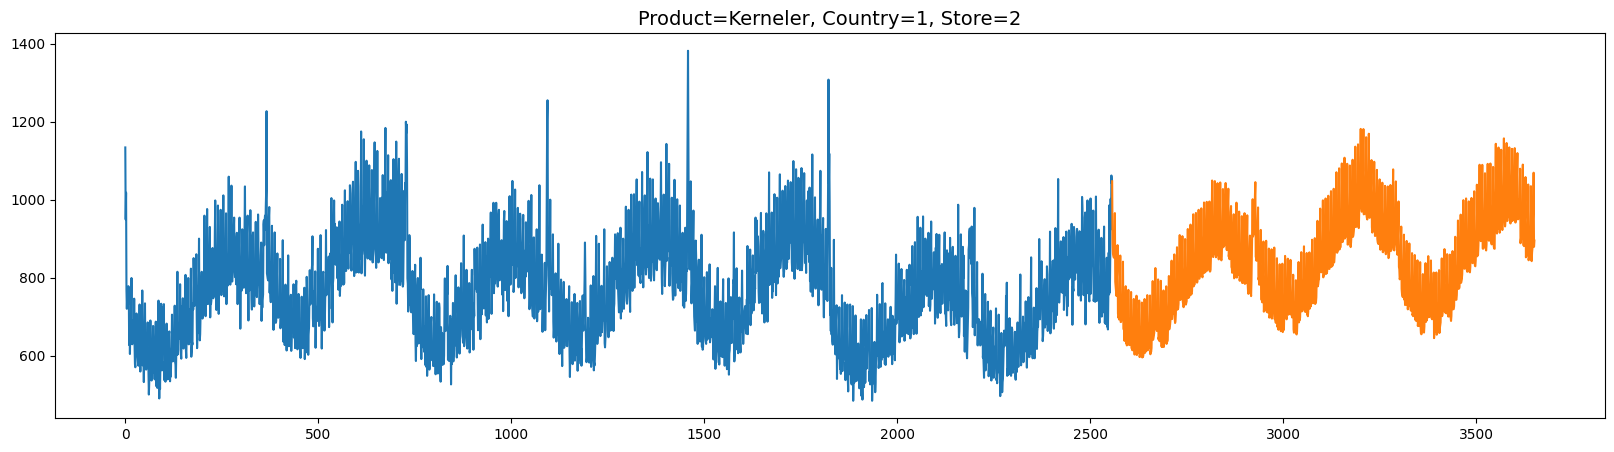

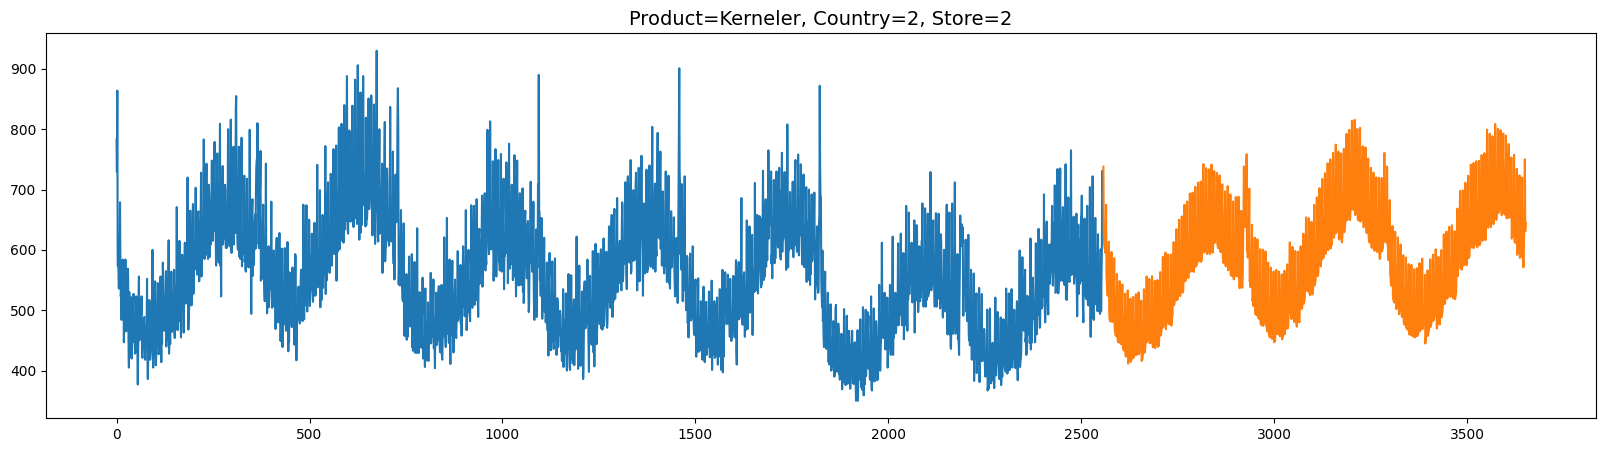

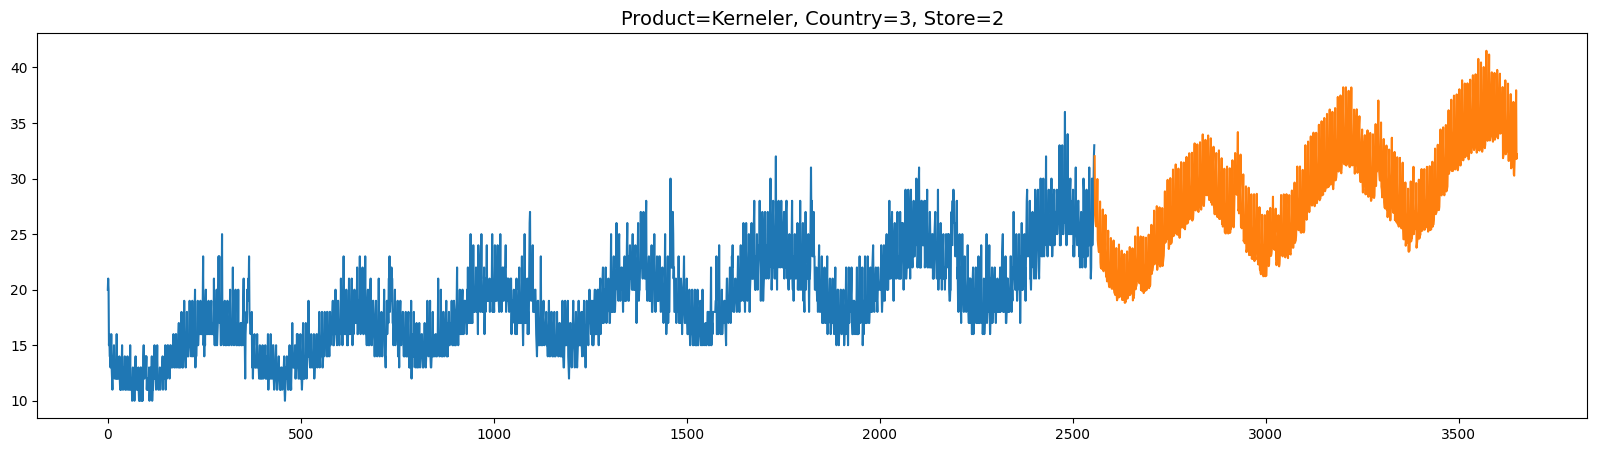

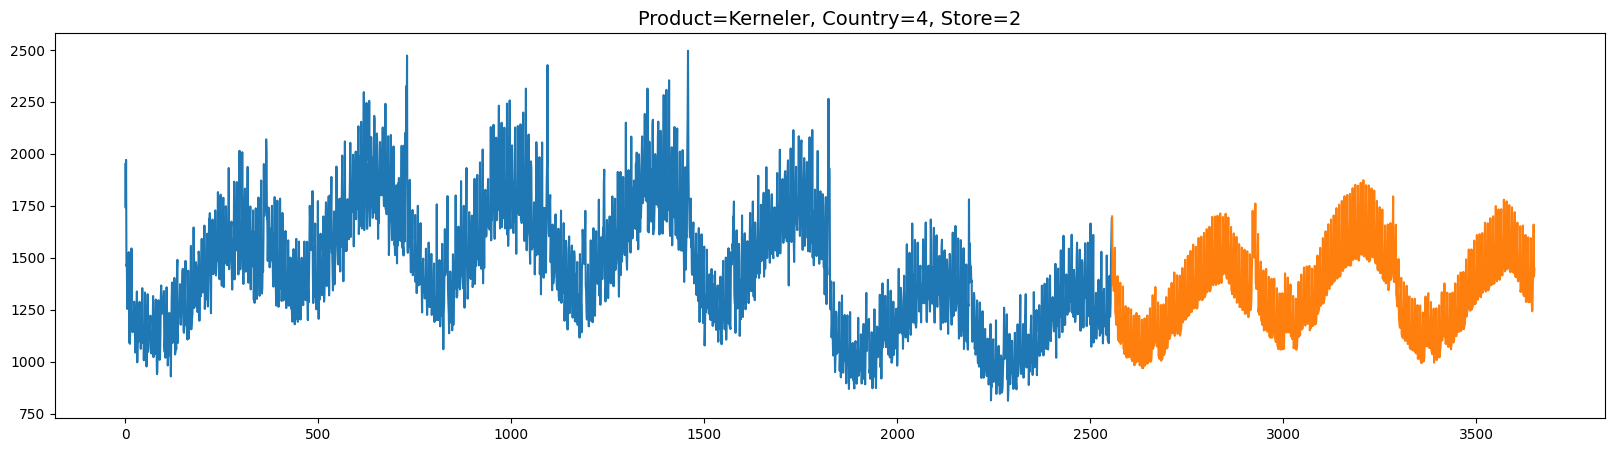

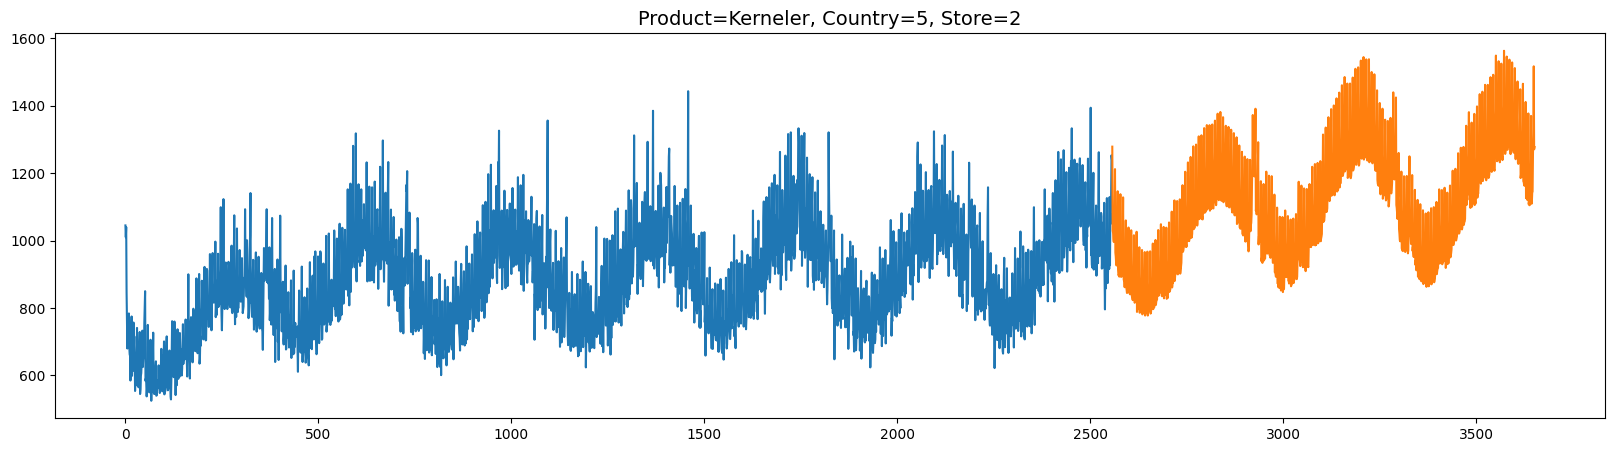

In [ ]:
for ss in range(3):
    for cc in range(6):
        df1 = train.loc[(train.country==C[cc])&(train['product']==P[PROD])&(train.store==S[ss])]
        df2 = test.loc[(test.country==C[cc])&(test['product']==P[PROD])&(test.store==S[ss])]

        plt.figure(figsize=(20,5))
        tmp = df1.num_sold * df1.GDP * df1.store_ratio
        tmp.iloc[0] = np.nan_to_num( tmp.iloc[0] )
        plt.plot(np.arange(len(df1)), tmp )
        plt.plot(np.arange(len(df2))+len(df1),df2.num_sold)
        plt.title(f"Product={P[PROD]}, Country={cc}, Store={ss}",size=14)
        plt.show()

In [ ]:
if PROD<4:
    test.to_csv(f"test_v{VER}_p{PROD}.csv",index=False)
    print(f"Saved partial predictions for product {P[PROD]} (PROD = {PROD})")
    print(f"Now run this notebook again with PROD = {PROD+1} to make more predictions.")
else:
    test[['id','num_sold']].to_csv(f"submission_v{VER}.csv",index=False)
    print(f"Wrote submission_v{VER}.csv, now submit to comp!")
test[['id','num_sold']].head()

Saved partial predictions for product Kerneler (PROD = 3)
Now run this notebook again with PROD = 4 to make more predictions.


id    num_sold
0  230130  135.984472
1  230131  863.719743
2  230132  659.514704
3  230133  412.032204
4  230134    0.000000